# TP - Implémentation PyTorch : Transition depuis Keras

## Exercice 2 - PyTorch

Ce notebook présente l'implémentation d'un CNN avec PyTorch, en revisitant les concepts précédemment abordés avec Keras. PyTorch offre un contrôle de bas niveau et une flexibilité accrue pour l'implémentation du deep learning.

## Objectifs du TP
- Maîtriser les concepts fondamentaux de PyTorch
- Implémenter un CNN depuis les bases avec PyTorch
- Comparer les approches PyTorch vs Keras
- Exploiter la flexibilité de PyTorch pour des customisations avancées

## Table des Matières
1. [Import PyTorch et bibliothèques essentielles](#1-import-pytorch-et-bibliothèques-essentielles)
2. [Création et manipulation de tenseurs](#2-création-et-manipulation-de-tenseurs)
3. [Architecture de réseau de neurones](#3-architecture-de-réseau-de-neurones)
4. [Fonction de perte et optimiseur](#4-fonction-de-perte-et-optimiseur)
5. [Préparation des données avec DataLoader](#5-préparation-des-données-avec-dataloader)
6. [Boucle d'entraînement](#6-boucle-dentraînement)
7. [Évaluation et test du modèle](#7-évaluation-et-test-du-modèle)
8. [Sauvegarde et chargement de modèles](#8-sauvegarde-et-chargement-de-modèles)
9. [Comparaison avec l'implémentation Keras](#9-comparaison-avec-limplémentation-keras)

## 1. Import PyTorch et bibliothèques essentielles

Nous commençons par importer PyTorch et toutes les bibliothèques nécessaires. PyTorch offre une approche plus modulaire que Keras.

In [29]:
# Installation de PyTorch si nécessaire
import subprocess
import sys

def install_package(package):
    """Installe un package Python"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installé avec succès")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ Erreur lors de l'installation de {package}: {e}")
        return False

def check_pytorch():
    """Vérifie si PyTorch est disponible"""
    try:
        import torch
        print(f"✅ PyTorch {torch.__version__} déjà disponible")
        return True
    except ImportError:
        print("❌ PyTorch non trouvé")
        return False

# Vérification et installation si nécessaire
print("🔍 Vérification de PyTorch...")
if not check_pytorch():
    print("📦 Installation de PyTorch en cours...")
    success = install_package("torch torchvision torchaudio")
    if success:
        print("🔍 Vérification après installation...")
        if check_pytorch():
            print("🎉 PyTorch installé et fonctionnel!")
        else:
            print("⚠️ Installation réussie mais import échoué. Redémarrez le kernel.")
    else:
        print("❌ Échec de l'installation. Essayez manuellement: !pip install torch torchvision")

🔍 Vérification de PyTorch...
✅ PyTorch 2.8.0+cu128 déjà disponible


In [31]:
# Fonction utilitaire pour sauvegarder les figures matplotlib dans un dossier
import os

def save_figure(fig, filename):
    """Sauvegarde la figure matplotlib dans le dossier pytorch_imgs"""
    save_dir = 'pytorch_imgs'
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, filename)
    fig.savefig(path, bbox_inches='tight')
    print(f"💾 Figure sauvegardée : {path}")

In [32]:
# Import des bibliothèques principales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms

# Bibliothèques pour la visualisation et l'analyse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
sns.set_palette("husl")

# Vérification du dispositif (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositif utilisé: {device}")

if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Affichage des versions
print(f"\n📚 Versions des bibliothèques:")
print(f"   PyTorch: {torch.__version__}")
print(f"   Torchvision: {torchvision.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")

# Configuration pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

🖥️ Dispositif utilisé: cpu

📚 Versions des bibliothèques:
   PyTorch: 2.8.0+cu128
   Torchvision: 0.23.0+cu128
   NumPy: 2.2.6
   Matplotlib: 3.10.5


## 2. Création et manipulation de tenseurs

Les tenseurs sont les structures de données fondamentales de PyTorch. Contrairement à Keras qui cache ces détails, PyTorch nous donne un contrôle complet sur les tenseurs.

In [33]:
# Création de tenseurs de différentes manières
print("🔧 Exemples de création de tenseurs:")

# Tenseur à partir d'une liste
tensor_from_list = torch.tensor([1, 2, 3, 4, 5])
print(f"Tenseur depuis liste: {tensor_from_list}")

# Tenseur de zéros
zeros_tensor = torch.zeros(3, 4)
print(f"\nTenseur de zéros (3x4):\n{zeros_tensor}")

# Tenseur aléatoire (important pour l'initialisation des poids)
random_tensor = torch.randn(2, 3, 4)  # Distribution normale
print(f"\nTenseur aléatoire (2x3x4) - forme: {random_tensor.shape}")

# Tenseur sur GPU si disponible
gpu_tensor = torch.randn(2, 3).to(device)
print(f"\nTenseur sur {device}: {gpu_tensor.device}")

# Opérations sur les tenseurs
print("\n🧮 Opérations sur les tenseurs:")
a = torch.randn(3, 4)
b = torch.randn(3, 4)

# Addition
c = a + b
print(f"Addition: forme {c.shape}")

# Multiplication matricielle
d = torch.matmul(a, b.t())  # .t() pour transposer
print(f"Multiplication matricielle: forme {d.shape}")

# Reshape (très important pour les CNN)
reshaped = a.view(-1)  # Aplatir
print(f"Tenseur aplati: forme {reshaped.shape}")

# Conversion vers NumPy (utile pour la visualisation)
numpy_array = a.detach().cpu().numpy()
print(f"Conversion vers NumPy: type {type(numpy_array)}")

🔧 Exemples de création de tenseurs:
Tenseur depuis liste: tensor([1, 2, 3, 4, 5])

Tenseur de zéros (3x4):
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Tenseur aléatoire (2x3x4) - forme: torch.Size([2, 3, 4])

Tenseur sur cpu: cpu

🧮 Opérations sur les tenseurs:
Addition: forme torch.Size([3, 4])
Multiplication matricielle: forme torch.Size([3, 3])
Tenseur aplati: forme torch.Size([12])
Conversion vers NumPy: type <class 'numpy.ndarray'>


## 3. Architecture de réseau de neurones

Avec PyTorch, nous définissons nos modèles en héritant de `nn.Module`. Cela nous donne un contrôle total sur l'architecture, contrairement à l'approche plus abstraite de Keras.

In [34]:
class SimpleCNN(nn.Module):
    """CNN simple pour la classification CIFAR-10
    
    Architecture similaire au modèle Keras précédent mais avec
    un contrôle explicite de chaque couche.
    """
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Première bloc convolutionnel
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                              kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Normalisation par batch
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Deuxième bloc convolutionnel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Troisième bloc convolutionnel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Couches fully connected
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # CIFAR-10: 32x32 -> 4x4 après 3 poolings
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        """Propagation avant - définit le flux de données"""
        # Premier bloc
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        
        # Deuxième bloc
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        
        # Troisième bloc
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        # Aplatissement et couches denses
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x
    
    def count_parameters(self):
        """Compte le nombre de paramètres du modèle"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Création et test du modèle
model = SimpleCNN(num_classes=10).to(device)
print(f"🏗️ Modèle créé avec {model.count_parameters():,} paramètres")

# Test avec un batch factice
test_input = torch.randn(1, 3, 32, 32).to(device)  # Batch de 1, 3 canaux, 32x32
with torch.no_grad():
    test_output = model(test_input)
    print(f"✅ Test réussi - sortie: {test_output.shape}")

# Affichage de l'architecture
print(f"\n📋 Architecture du modèle:")
print(model)

🏗️ Modèle créé avec 1,147,914 paramètres
✅ Test réussi - sortie: torch.Size([1, 10])

📋 Architecture du modèle:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim

## 4. Fonction de perte et optimiseur

PyTorch nous permet de choisir et configurer explicitement la fonction de perte et l'optimiseur, offrant plus de flexibilité que Keras.

In [35]:
# Fonction de perte pour la classification
criterion = nn.CrossEntropyLoss()
print(f"📊 Fonction de perte: {criterion.__class__.__name__}")

# Optimiseur Adam avec taux d'apprentissage adaptatif
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print(f"🚀 Optimiseur: {optimizer.__class__.__name__}")
print(f"   Taux d'apprentissage: {optimizer.param_groups[0]['lr']}")
print(f"   Weight decay: {optimizer.param_groups[0]['weight_decay']}")

# Scheduler pour ajuster le taux d'apprentissage
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(f"📈 Scheduler: {scheduler.__class__.__name__}")

# Alternative: scheduler plus sophistiqué
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
#                                                 factor=0.5, patience=3)

print("\n🔧 Configuration d'entraînement prête!")
print(f"   Modèle: {model.__class__.__name__}")
print(f"   Dispositif: {next(model.parameters()).device}")
print(f"   Paramètres: {model.count_parameters():,}")

📊 Fonction de perte: CrossEntropyLoss
🚀 Optimiseur: Adam
   Taux d'apprentissage: 0.001
   Weight decay: 0.0001
📈 Scheduler: StepLR

🔧 Configuration d'entraînement prête!
   Modèle: SimpleCNN
   Dispositif: cpu
   Paramètres: 1,147,914


## 5. Préparation des données avec DataLoader

PyTorch utilise DataLoader pour gérer efficacement les données. Nous allons charger CIFAR-10 et appliquer des transformations, équivalent à ce qui était fait avec Keras.

In [36]:
# Transformations pour l'augmentation de données (équivalent à ImageDataGenerator de Keras)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Retournement horizontal
    transforms.RandomRotation(degrees=10),   # Rotation aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Ajustement couleurs
    transforms.ToTensor(),                   # Conversion en tenseur
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # Normalisation CIFAR-10
                        std=[0.2023, 0.1994, 0.2010])
])

# Transformations pour la validation (pas d'augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                        std=[0.2023, 0.1994, 0.2010])
])

# Chargement du dataset CIFAR-10
print("📥 Chargement du dataset CIFAR-10...")
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

# Division train/validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes CIFAR-10
classes = ['avion', 'automobile', 'oiseau', 'chat', 'cerf', 
          'chien', 'grenouille', 'cheval', 'bateau', 'camion']

print(f"✅ Dataset chargé:")
print(f"   Entraînement: {len(train_dataset)} images")
print(f"   Validation: {len(val_dataset)} images")
print(f"   Test: {len(test_dataset)} images")
print(f"   Taille de batch: {batch_size}")
print(f"   Nombre de classes: {len(classes)}")

📥 Chargement du dataset CIFAR-10...


✅ Dataset chargé:
   Entraînement: 40000 images
   Validation: 10000 images
   Test: 10000 images
   Taille de batch: 128
   Nombre de classes: 10


🖼️ Visualisation d'exemples du dataset:


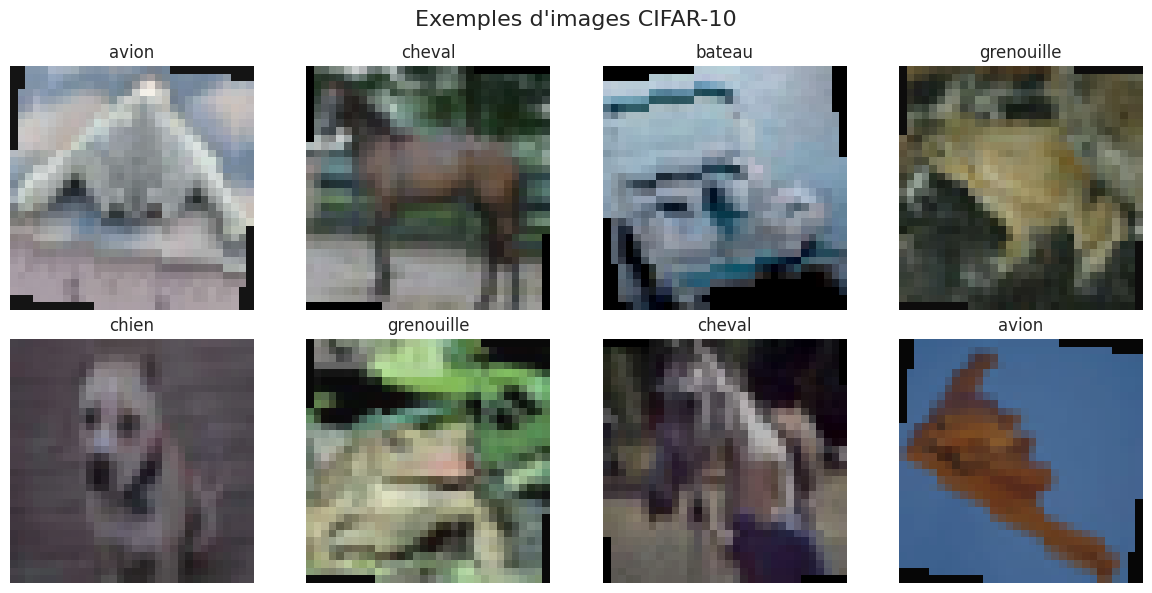

In [37]:
# Visualisation de quelques exemples du dataset
def show_sample_images(dataloader, num_images=8):
    """Affiche des images d'exemple du dataset"""
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    
    # Dénormalisation pour l'affichage
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    fig.suptitle('Exemples d\'images CIFAR-10', fontsize=16)
    
    for i in range(num_images):
        row, col = i // 4, i % 4
        img = images[i].permute(1, 2, 0)  # CHW -> HWC pour matplotlib
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'{classes[labels[i]]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

print("🖼️ Visualisation d'exemples du dataset:")
show_sample_images(train_loader)

## 6. Boucle d'entraînement

Contrairement à Keras qui utilise `model.fit()`, PyTorch nécessite que nous écrivions explicitement la boucle d'entraînement. Cela offre plus de contrôle sur le processus.

In [38]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîne le modèle pendant une époque"""
    model.train()  # Mode entraînement
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Déplacer les données sur le bon dispositif
        data, target = data.to(device), target.to(device)
        
        # Remise à zéro des gradients
        optimizer.zero_grad()
        
        # Propagation avant
        output = model(data)
        
        # Calcul de la perte
        loss = criterion(output, target)
        
        # Rétropropagation
        loss.backward()
        
        # Mise à jour des paramètres
        optimizer.step()
        
        # Statistiques
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()
        
        # Affichage du progrès
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Perte: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Évalue le modèle sur les données de validation"""
    model.eval()  # Mode évaluation
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Pas de calcul de gradients
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

print("🏃‍♂️ Fonctions d'entraînement et de validation définies")
print("📊 Prêt pour l'entraînement du modèle")

🏃‍♂️ Fonctions d'entraînement et de validation définies
📊 Prêt pour l'entraînement du modèle


In [39]:
# Entraînement du modèle
num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_acc = 0.0

print(f"🚀 Début de l'entraînement pour {num_epochs} époques")
print(f"📱 Dispositif: {device}")
print("-" * 70)

for epoch in range(num_epochs):
    print(f"\nÉpoque {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Mise à jour du scheduler
    scheduler.step()
    
    # Sauvegarde des métriques
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_pytorch_model.pth')
        print(f"💾 Nouveau meilleur modèle sauvegardé (val_acc: {val_acc:.2f}%)")
    
    # Affichage des résultats de l'époque
    print(f"Train - Perte: {train_loss:.4f}, Précision: {train_acc:.2f}%")
    print(f"Val   - Perte: {val_loss:.4f}, Précision: {val_acc:.2f}%")
    print(f"LR actuel: {optimizer.param_groups[0]['lr']:.6f}")

print(f"\n🎉 Entraînement terminé!")
print(f"🏆 Meilleure précision de validation: {best_val_acc:.2f}%")

🚀 Début de l'entraînement pour 20 époques
📱 Dispositif: cpu
----------------------------------------------------------------------

Époque 1/20
------------------------------
Batch 0/313, Perte: 2.4341
Batch 100/313, Perte: 1.6170
Batch 200/313, Perte: 1.5417
Batch 300/313, Perte: 1.3458
💾 Nouveau meilleur modèle sauvegardé (val_acc: 55.77%)
Train - Perte: 1.5702, Précision: 42.59%
Val   - Perte: 1.2439, Précision: 55.77%
LR actuel: 0.001000

Époque 2/20
------------------------------
Batch 0/313, Perte: 1.2513
Batch 100/313, Perte: 1.2256
Batch 200/313, Perte: 1.2088
Batch 300/313, Perte: 1.1178
💾 Nouveau meilleur modèle sauvegardé (val_acc: 56.87%)
Train - Perte: 1.2620, Précision: 54.59%
Val   - Perte: 1.1966, Précision: 56.87%
LR actuel: 0.001000

Époque 3/20
------------------------------
Batch 0/313, Perte: 1.2128
Batch 100/313, Perte: 1.2319
Batch 200/313, Perte: 1.2687
Batch 300/313, Perte: 0.9066
💾 Nouveau meilleur modèle sauvegardé (val_acc: 62.04%)
Train - Perte: 1.1407, Pré

## 7. Évaluation et test du modèle

Évaluons les performances de notre modèle PyTorch et visualisons les résultats.

📈 Visualisation des résultats d'entraînement:


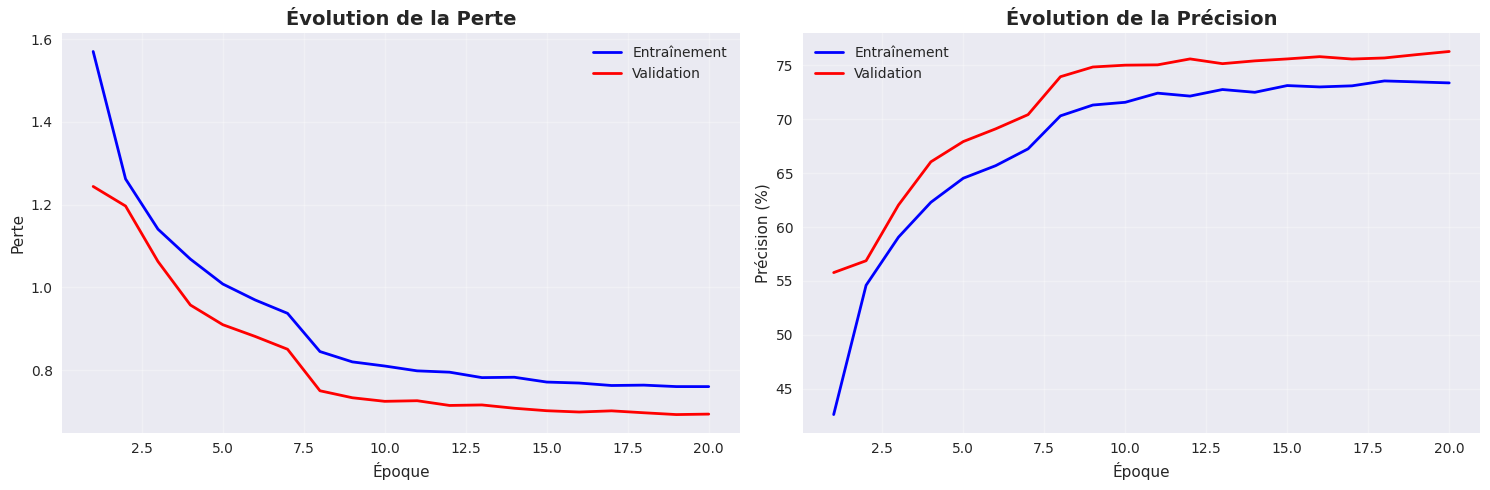

In [40]:
# Visualisation des courbes d'entraînement
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Affiche les courbes de perte et de précision"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Courbes de perte
    ax1.plot(epochs, train_losses, 'b-', label='Entraînement', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation', linewidth=2)
    ax1.set_title('Évolution de la Perte', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Perte')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Courbes de précision
    ax2.plot(epochs, train_accuracies, 'b-', label='Entraînement', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation', linewidth=2)
    ax2.set_title('Évolution de la Précision', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Précision (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Affichage des courbes
print("📈 Visualisation des résultats d'entraînement:")
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [41]:
# Chargement du meilleur modèle et évaluation sur le test
model.load_state_dict(torch.load('best_pytorch_model.pth'))
model.eval()

def evaluate_model(model, test_loader, device):
    """Évaluation complète du modèle"""
    model.eval()
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_targets

# Évaluation
test_accuracy, predictions, targets = evaluate_model(model, test_loader, device)
print(f"🎯 Précision sur le test: {test_accuracy:.2f}%")

# Rapport de classification détaillé
print("\n📊 Rapport de classification:")
print(classification_report(targets, predictions, target_names=classes))

🎯 Précision sur le test: 77.88%

📊 Rapport de classification:
              precision    recall  f1-score   support

       avion       0.79      0.83      0.81      1000
  automobile       0.88      0.89      0.89      1000
      oiseau       0.72      0.63      0.67      1000
        chat       0.61      0.57      0.59      1000
        cerf       0.73      0.76      0.74      1000
       chien       0.68      0.69      0.69      1000
  grenouille       0.83      0.84      0.83      1000
      cheval       0.80      0.83      0.82      1000
      bateau       0.87      0.87      0.87      1000
      camion       0.85      0.88      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



🔥 Matrice de confusion:


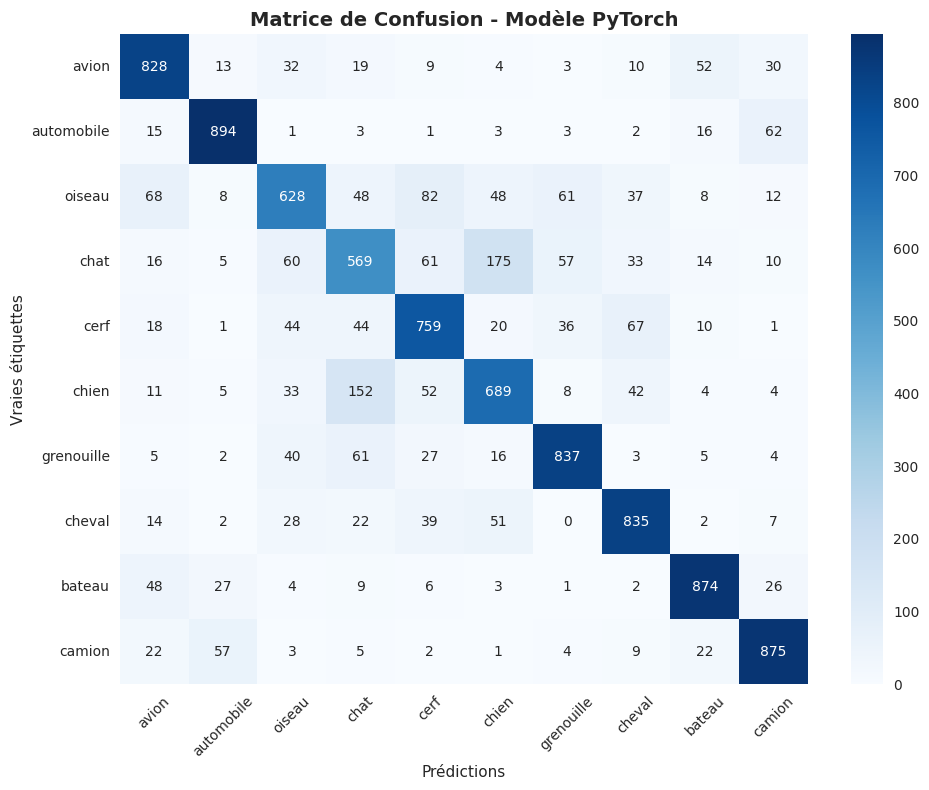

In [42]:
# Matrice de confusion
def plot_confusion_matrix(targets, predictions, classes):
    """Affiche la matrice de confusion"""
    cm = confusion_matrix(targets, predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matrice de Confusion - Modèle PyTorch', fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("🔥 Matrice de confusion:")
plot_confusion_matrix(targets, predictions, classes)

## 8. Sauvegarde et chargement de modèles

PyTorch offre plusieurs méthodes pour sauvegarder et charger des modèles. Voici les meilleures pratiques.

In [43]:
# Sauvegarde complète du modèle
def save_complete_model(model, optimizer, epoch, loss, accuracy, filepath):
    """Sauvegarde complète incluant l'état de l'optimiseur"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'model_architecture': str(model)
    }
    torch.save(checkpoint, filepath)
    print(f"💾 Modèle complet sauvegardé: {filepath}")

# Chargement complet du modèle
def load_complete_model(model, optimizer, filepath, device):
    """Charge un modèle complet"""
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    
    print(f"📂 Modèle chargé depuis: {filepath}")
    print(f"   Époque: {epoch}")
    print(f"   Perte: {loss:.4f}")
    print(f"   Précision: {accuracy:.2f}%")
    
    return epoch, loss, accuracy

# Sauvegarde du modèle final
final_checkpoint_path = 'pytorch_cnn_final_checkpoint.pth'
save_complete_model(model, optimizer, num_epochs, val_losses[-1], 
                   val_accuracies[-1], final_checkpoint_path)

# Sauvegarde pour déploiement (modèle seulement)
torch.save(model.state_dict(), 'pytorch_cnn_deployment.pth')
print("💾 Modèle de déploiement sauvegardé: pytorch_cnn_deployment.pth")

# Sauvegarde du modèle entier (alternative)
torch.save(model, 'pytorch_cnn_complete.pth')
print("💾 Modèle entier sauvegardé: pytorch_cnn_complete.pth")

print("\n✅ Toutes les sauvegardes terminées!")

💾 Modèle complet sauvegardé: pytorch_cnn_final_checkpoint.pth
💾 Modèle de déploiement sauvegardé: pytorch_cnn_deployment.pth
💾 Modèle entier sauvegardé: pytorch_cnn_complete.pth

✅ Toutes les sauvegardes terminées!


## 9. Comparaison avec l'implémentation Keras

Comparons les approches PyTorch et Keras pour mieux comprendre les avantages de chaque framework.

In [44]:
# Tableau comparatif PyTorch vs Keras
comparison_data = {
    'Aspect': [
        'Définition du modèle',
        'Boucle d\'entraînement',
        'Gestion des données',
        'Optimisation',
        'Debugging',
        'Flexibilité',
        'Courbe d\'apprentissage',
        'Performance',
        'Recherche vs Production'
    ],
    'PyTorch': [
        'Classes héritant de nn.Module',
        'Écrite manuellement (contrôle total)',
        'DataLoader personnalisables',
        'Optimiseurs explicites',
        'Excellent (Python natif)',
        'Très élevée',
        'Plus raide',
        'Excellente',
        'Parfait pour la recherche'
    ],
    'Keras': [
        'API Sequential/Functional',
        'model.fit() automatique',
        'ImageDataGenerator simple',
        'Intégrés dans compile()',
        'Plus difficile',
        'Limitée',
        'Plus douce',
        'Bonne',
        'Idéal pour débuter'
    ]
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("📊 Comparaison PyTorch vs Keras:")
print(comparison_df.to_string(index=False))

print("\n🔍 Avantages de PyTorch:")
print("• Contrôle total sur la boucle d'entraînement")
print("• Debugging plus facile (Python natif)")
print("• Flexibilité pour architectures complexes")
print("• Gradient computation dynamique")
print("• Idéal pour la recherche et l'expérimentation")

print("\n🔍 Avantages de Keras:")
print("• API plus simple et intuitive")
print("• Prototypage rapide")
print("• Moins de code nécessaire")
print("• Parfait pour débuter en deep learning")
print("• Intégration TensorFlow pour le déploiement")

📊 Comparaison PyTorch vs Keras:
                 Aspect                              PyTorch                     Keras
   Définition du modèle        Classes héritant de nn.Module API Sequential/Functional
  Boucle d'entraînement Écrite manuellement (contrôle total)   model.fit() automatique
    Gestion des données          DataLoader personnalisables ImageDataGenerator simple
           Optimisation               Optimiseurs explicites   Intégrés dans compile()
              Debugging             Excellent (Python natif)            Plus difficile
            Flexibilité                          Très élevée                   Limitée
 Courbe d'apprentissage                           Plus raide                Plus douce
            Performance                           Excellente                     Bonne
Recherche vs Production            Parfait pour la recherche        Idéal pour débuter

🔍 Avantages de PyTorch:
• Contrôle total sur la boucle d'entraînement
• Debugging plus facile (Py

In [45]:
# Démonstration de flexibilité PyTorch: Architecture personnalisée
class FlexibleCNN(nn.Module):
    """Exemple d'architecture plus flexible avec PyTorch"""
    
    def __init__(self, num_classes=10):
        super(FlexibleCNN, self).__init__()
        
        # Bloc résiduel simple
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.shortcut = nn.Conv2d(3, 64, 1)  # Connexion résiduelle
        
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 16 * 16, num_classes)
        
    def forward(self, x):
        # Connexion résiduelle (difficile à faire avec Keras Sequential)
        identity = self.shortcut(x)
        
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += identity  # Addition résiduelle
        out = F.relu(out)
        
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

# Test de l'architecture flexible
flexible_model = FlexibleCNN().to(device)
print(f"🏗️ Modèle flexible créé avec {sum(p.numel() for p in flexible_model.parameters()):,} paramètres")

# Test
test_input = torch.randn(1, 3, 32, 32).to(device)
with torch.no_grad():
    output = flexible_model(test_input)
    print(f"✅ Architecture flexible testée avec succès")

print("\n💡 Cette flexibilité est l'un des grands avantages de PyTorch!")
print("   Vous pouvez implémenter facilement:")
print("   • Connexions résiduelles")
print("   • Attention mechanisms")
print("   • Architectures complexes")
print("   • Boucles d'entraînement personnalisées")

🏗️ Modèle flexible créé avec 202,826 paramètres
✅ Architecture flexible testée avec succès

💡 Cette flexibilité est l'un des grands avantages de PyTorch!
   Vous pouvez implémenter facilement:
   • Connexions résiduelles
   • Attention mechanisms
   • Architectures complexes
   • Boucles d'entraînement personnalisées


## Conclusion

🎉 **Félicitations !** Vous avez maintenant implémenté un CNN complet avec PyTorch et comparé les approches avec Keras.

### Points clés retenus :

1. **PyTorch offre plus de contrôle** : Chaque aspect de l'entraînement est explicite
2. **Flexibilité architecturale** : Plus facile d'implémenter des architectures complexes
3. **Debugging amélioré** : Le code Python natif facilite le debugging
4. **Boucles d'entraînement personnalisées** : Contrôle total sur le processus d'optimisation

### Prochaines étapes suggérées :

- Expérimentez avec des architectures plus complexes (ResNet, DenseNet)
- Implémentez des techniques avancées (attention, batch normalization)
- Explorez les hooks PyTorch pour visualiser les activations
- Tentez le transfer learning avec des modèles pré-entraînés

**PyTorch vous donne les outils pour aller plus loin dans vos implémentations de deep learning !** 🚀

## 10. Visualisations Avancées

Cette section présente des visualisations sophistiquées pour mieux comprendre le comportement du modèle et analyser les performances en profondeur.

🔍 Analyse détaillée des prédictions...


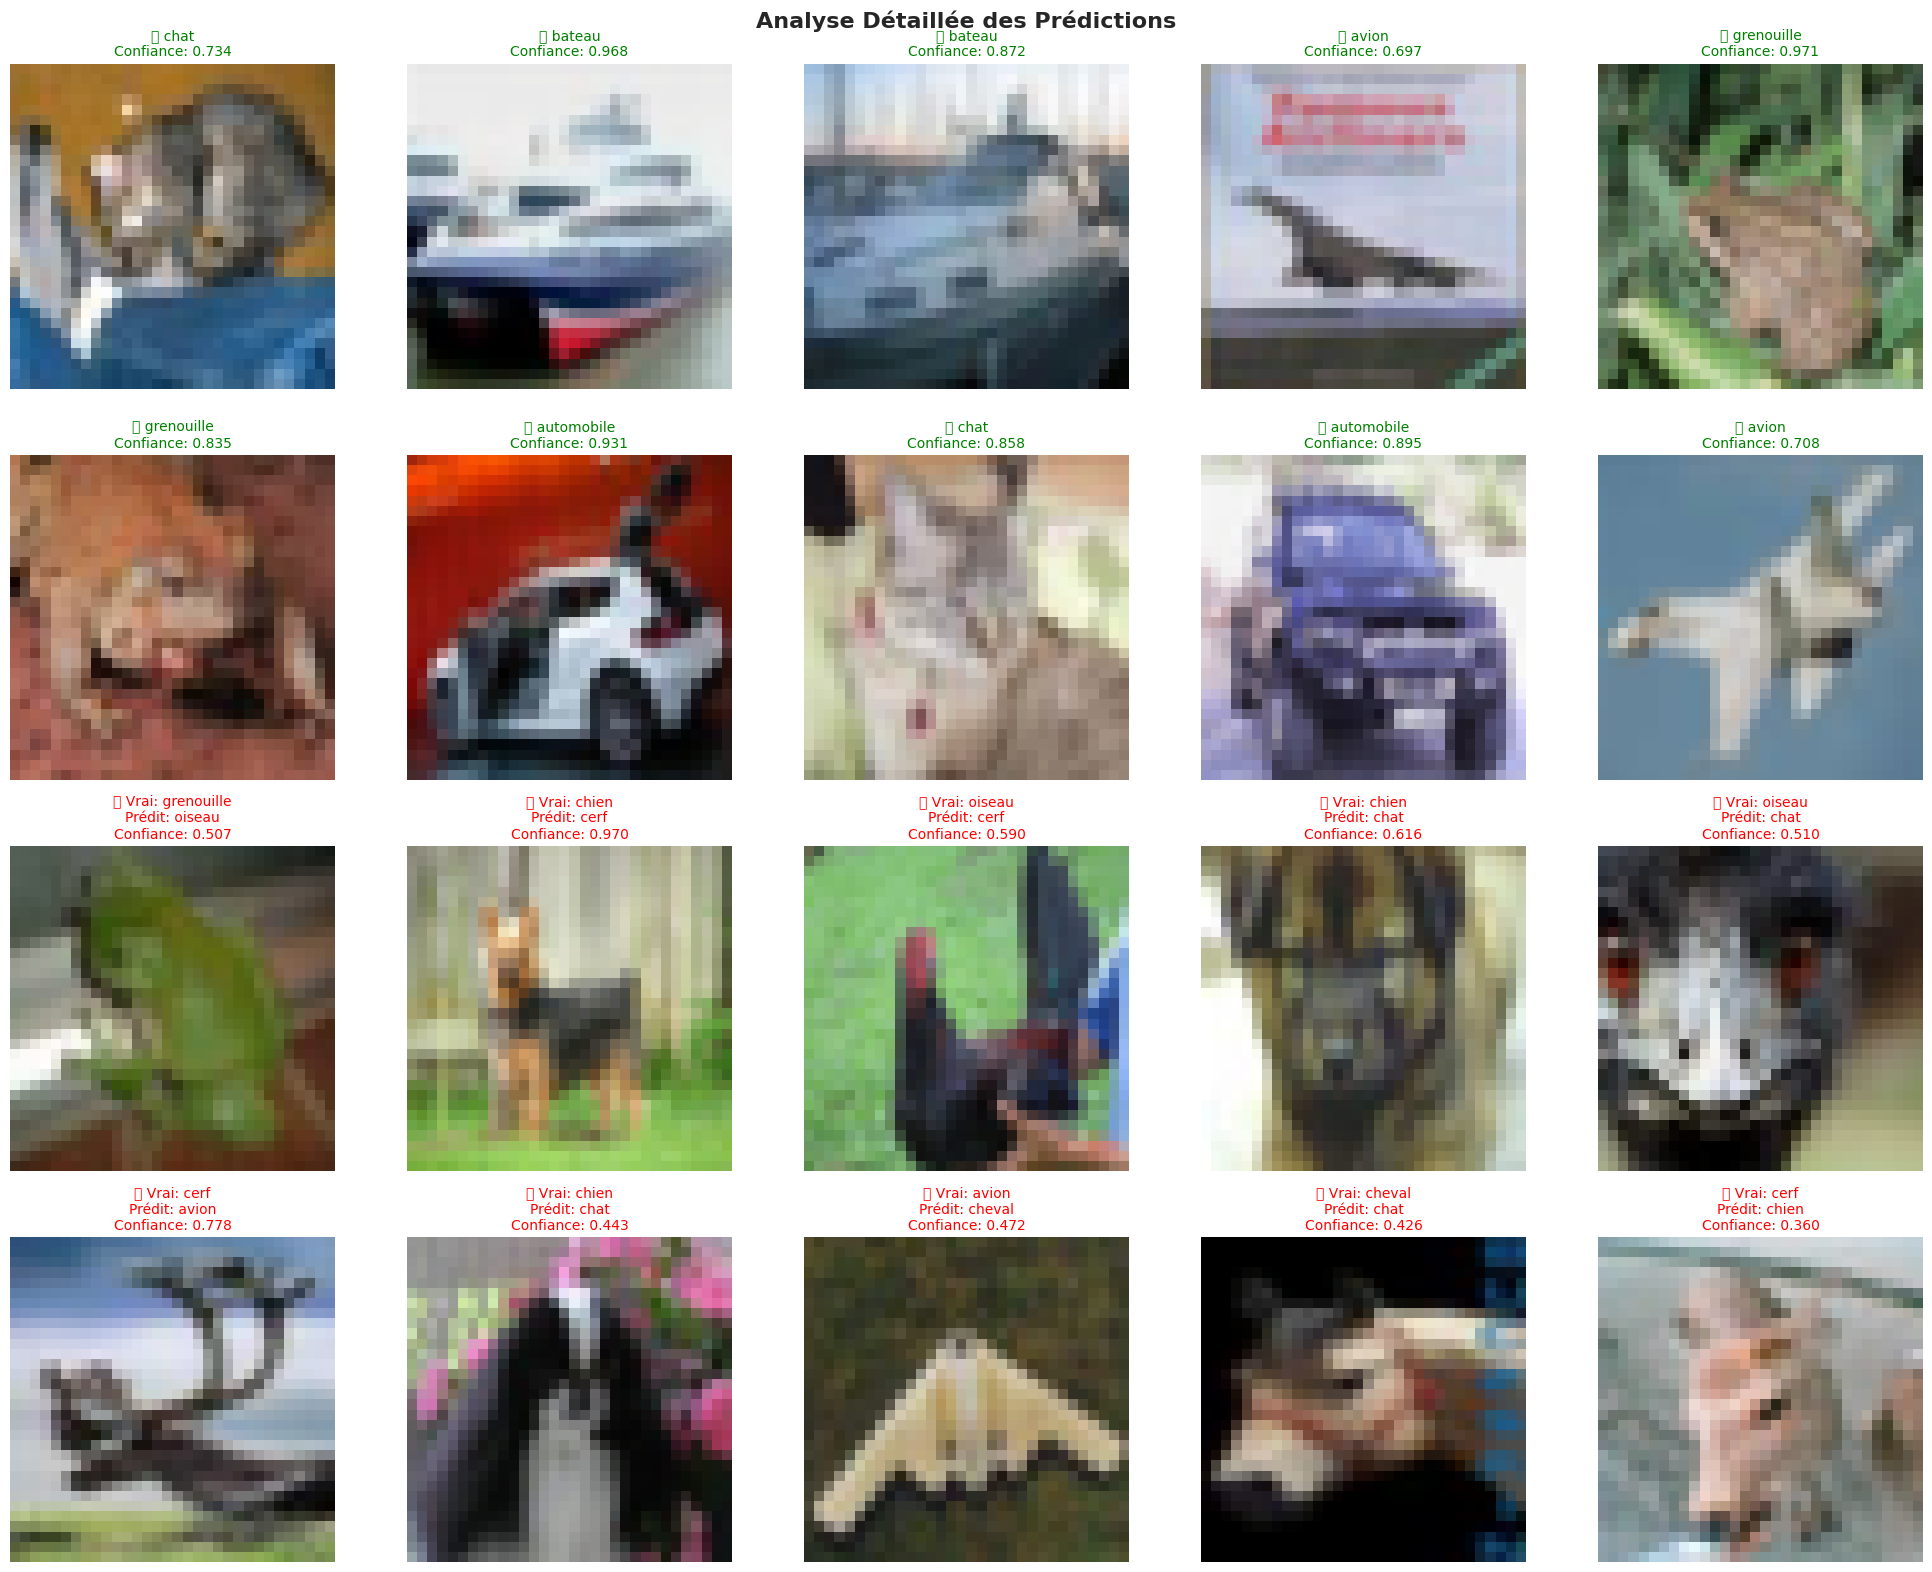

In [46]:
# Visualisation des prédictions avec images mal classées
def visualize_predictions_detailed(model, test_loader, device, classes, num_samples=20):
    """Affiche des exemples de prédictions correctes et incorrectes"""
    model.eval()
    correct_samples = []
    incorrect_samples = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(data.size(0)):
                sample_info = {
                    'image': data[i].cpu(),
                    'true_label': target[i].item(),
                    'predicted_label': predicted[i].item(),
                    'confidence': probabilities[i][predicted[i]].item(),
                    'probabilities': probabilities[i].cpu().numpy()
                }
                
                if target[i] == predicted[i]:
                    correct_samples.append(sample_info)
                else:
                    incorrect_samples.append(sample_info)
                
                if len(correct_samples) >= num_samples//2 and len(incorrect_samples) >= num_samples//2:
                    break
            
            if len(correct_samples) >= num_samples//2 and len(incorrect_samples) >= num_samples//2:
                break
    
    # Dénormalisation pour l'affichage
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    fig.suptitle('Analyse Détaillée des Prédictions', fontsize=16, fontweight='bold')
    
    # Prédictions correctes (2 premières lignes)
    for i in range(10):
        row, col = i // 5, i % 5
        sample = correct_samples[i]
        
        # Dénormalisation
        img = sample['image'] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"✅ {classes[sample['true_label']]}\n"
            f"Confiance: {sample['confidence']:.3f}",
            fontsize=10, color='green'
        )
        axes[row, col].axis('off')
    
    # Prédictions incorrectes (2 dernières lignes)
    for i in range(10):
        row, col = (i // 5) + 2, i % 5
        sample = incorrect_samples[i]
        
        # Dénormalisation
        img = sample['image'] * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        axes[row, col].imshow(img)
        axes[row, col].set_title(
            f"❌ Vrai: {classes[sample['true_label']]}\n"
            f"Prédit: {classes[sample['predicted_label']]}\n"
            f"Confiance: {sample['confidence']:.3f}",
            fontsize=10, color='red'
        )
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return correct_samples, incorrect_samples

print("🔍 Analyse détaillée des prédictions...")
correct_samples, incorrect_samples = visualize_predictions_detailed(model, test_loader, device, classes)

🔧 Visualisation des filtres convolutionnels...


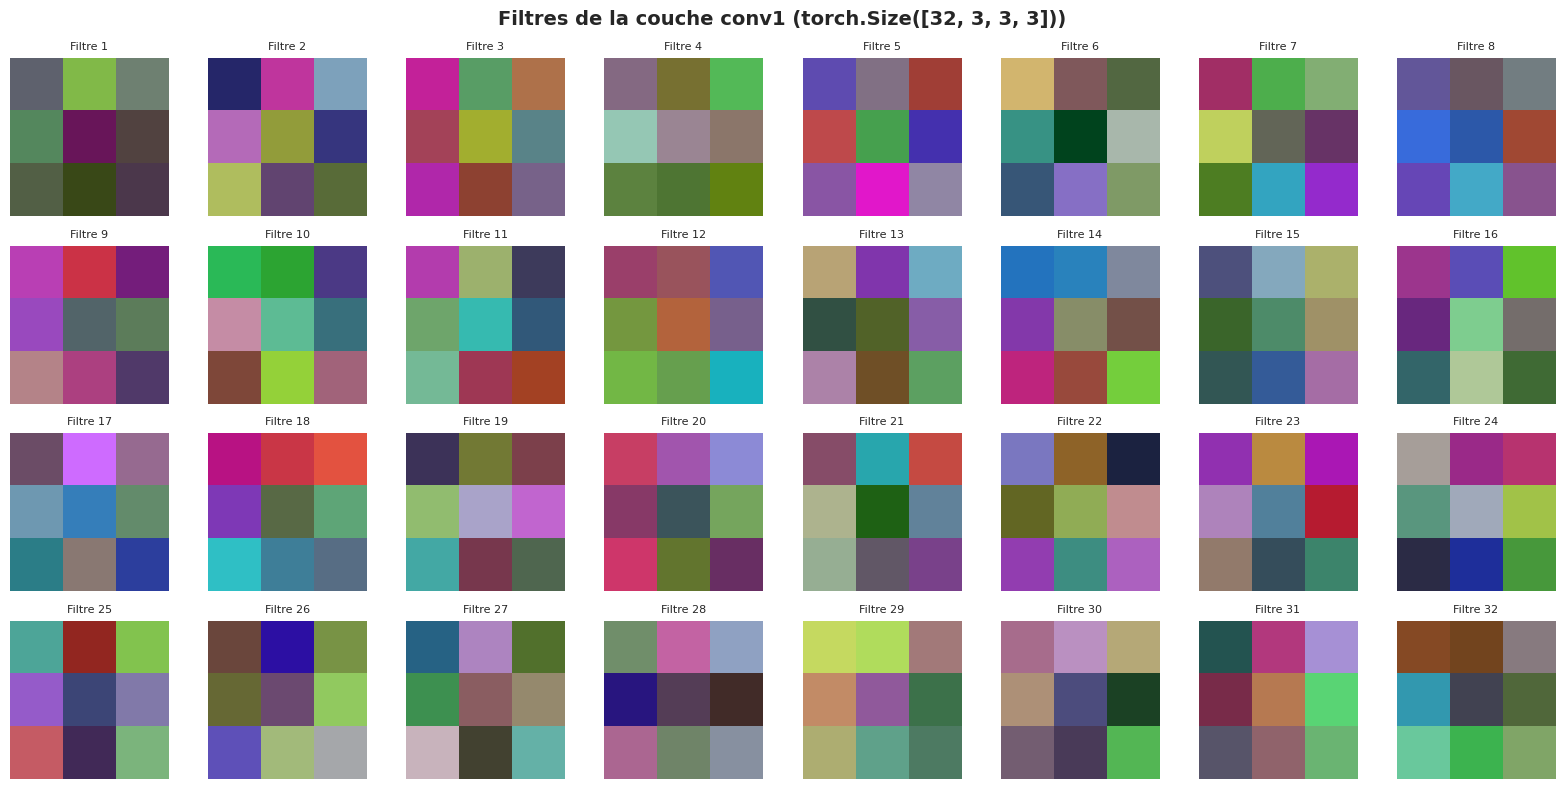

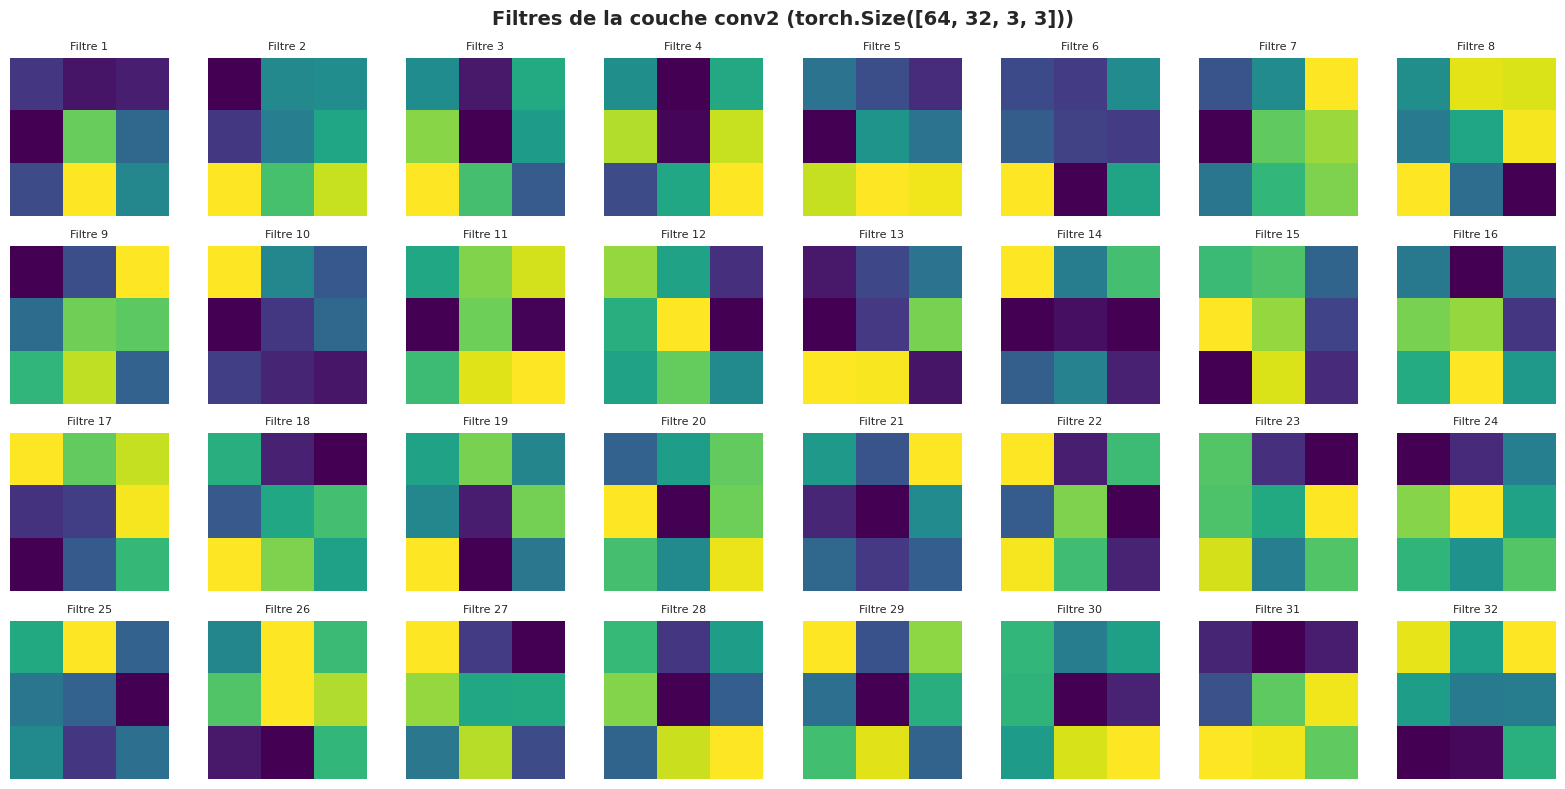

In [47]:
# Visualisation des filtres convolutionnels
def visualize_conv_filters(model, layer_name='conv1', max_filters=32):
    """Visualise les filtres d'une couche convolutionnelle"""
    # Récupération des poids de la couche
    layer = getattr(model, layer_name)
    weights = layer.weight.data.cpu()
    
    # Normalisation des poids pour l'affichage
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    num_filters = min(weights.shape[0], max_filters)
    cols = 8
    rows = (num_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 2))
    fig.suptitle(f'Filtres de la couche {layer_name} ({weights.shape})', fontsize=14, fontweight='bold')
    
    for i in range(num_filters):
        row, col = i // cols, i % cols
        if rows == 1:
            ax = axes[col] if cols > 1 else axes
        else:
            ax = axes[row, col]
        
        # Pour les filtres RGB, on affiche la moyenne des canaux
        if weights.shape[1] == 3:  # RGB
            filter_img = weights[i].permute(1, 2, 0).numpy()
        else:  # Grayscale ou feature maps
            filter_img = weights[i, 0].numpy()
        
        ax.imshow(filter_img, cmap='viridis' if weights.shape[1] != 3 else None)
        ax.set_title(f'Filtre {i+1}', fontsize=8)
        ax.axis('off')
    
    # Masquer les axes non utilisés
    for i in range(num_filters, rows * cols):
        row, col = i // cols, i % cols
        if rows == 1:
            ax = axes[col] if cols > 1 else axes
        else:
            ax = axes[row, col]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("🔧 Visualisation des filtres convolutionnels...")
visualize_conv_filters(model, 'conv1', 32)
visualize_conv_filters(model, 'conv2', 32)

🗺️ Visualisation des cartes d'activation...


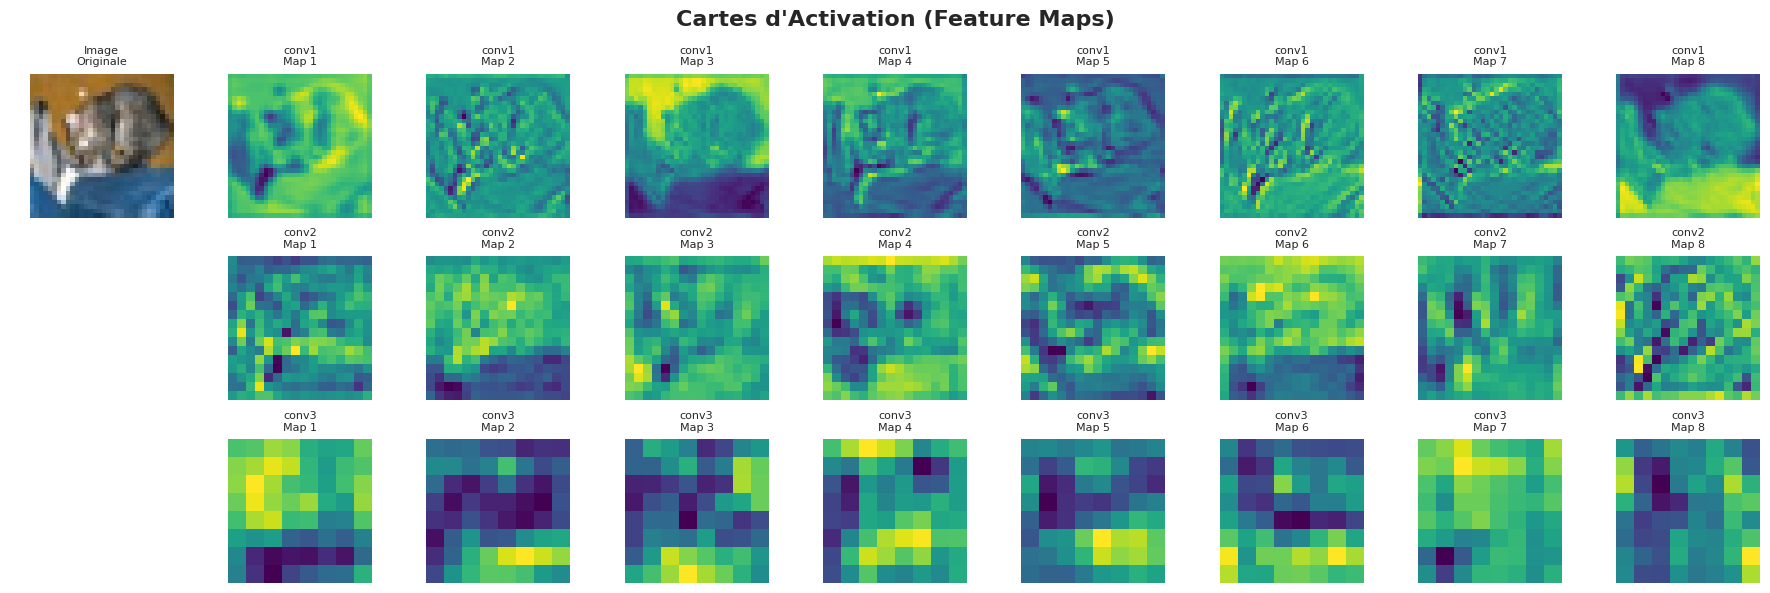

\n📊 Statistiques des activations:
conv1 : Forme=torch.Size([32, 32, 32]), Min=-4.337, Max=3.718, Moyenne=0.016
conv2 : Forme=torch.Size([64, 16, 16]), Min=-8.314, Max=3.920, Moyenne=-0.937
conv3 : Forme=torch.Size([128, 8, 8]), Min=-7.448, Max=3.718, Moyenne=-0.836


In [48]:
# Visualisation des cartes d'activation (Feature Maps)
def visualize_feature_maps(model, test_loader, device, layer_names=['conv1', 'conv2', 'conv3']):
    """Visualise les cartes d'activation pour différentes couches"""
    model.eval()
    
    # Récupération d'une image de test
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    image = images[0:1].to(device)  # Premier échantillon
    
    # Hooks pour capturer les activations
    activations = {}
    hooks = []
    
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Enregistrement des hooks
    for layer_name in layer_names:
        layer = getattr(model, layer_name)
        hook = layer.register_forward_hook(get_activation(layer_name))
        hooks.append(hook)
    
    # Propagation avant pour capturer les activations
    with torch.no_grad():
        _ = model(image)
    
    # Suppression des hooks
    for hook in hooks:
        hook.remove()
    
    # Visualisation
    fig, axes = plt.subplots(len(layer_names), 9, figsize=(18, len(layer_names) * 2))
    fig.suptitle('Cartes d\'Activation (Feature Maps)', fontsize=16, fontweight='bold')
    
    for layer_idx, layer_name in enumerate(layer_names):
        activation = activations[layer_name][0].cpu()  # Premier échantillon du batch
        
        # Affichage de l'image originale dans la première colonne
        if layer_idx == 0:
            # Dénormalisation de l'image originale
            mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
            std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
            orig_img = image[0].cpu() * std + mean
            orig_img = torch.clamp(orig_img, 0, 1)
            
            axes[layer_idx, 0].imshow(orig_img.permute(1, 2, 0))
            axes[layer_idx, 0].set_title('Image\nOriginale', fontsize=8)
            axes[layer_idx, 0].axis('off')
        else:
            axes[layer_idx, 0].axis('off')
        
        # Affichage des feature maps
        for i in range(8):  # 8 feature maps
            if i < activation.shape[0]:
                feature_map = activation[i].numpy()
                axes[layer_idx, i+1].imshow(feature_map, cmap='viridis')
                axes[layer_idx, i+1].set_title(f'{layer_name}\nMap {i+1}', fontsize=8)
            axes[layer_idx, i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques des activations
    print("\\n📊 Statistiques des activations:")
    for layer_name in layer_names:
        activation = activations[layer_name][0].cpu()
        print(f"{layer_name:6s}: Forme={activation.shape}, "
              f"Min={activation.min():.3f}, Max={activation.max():.3f}, "
              f"Moyenne={activation.mean():.3f}")

print("🗺️ Visualisation des cartes d'activation...")
visualize_feature_maps(model, test_loader, device)

📊 Analyse approfondie des probabilités de classe...


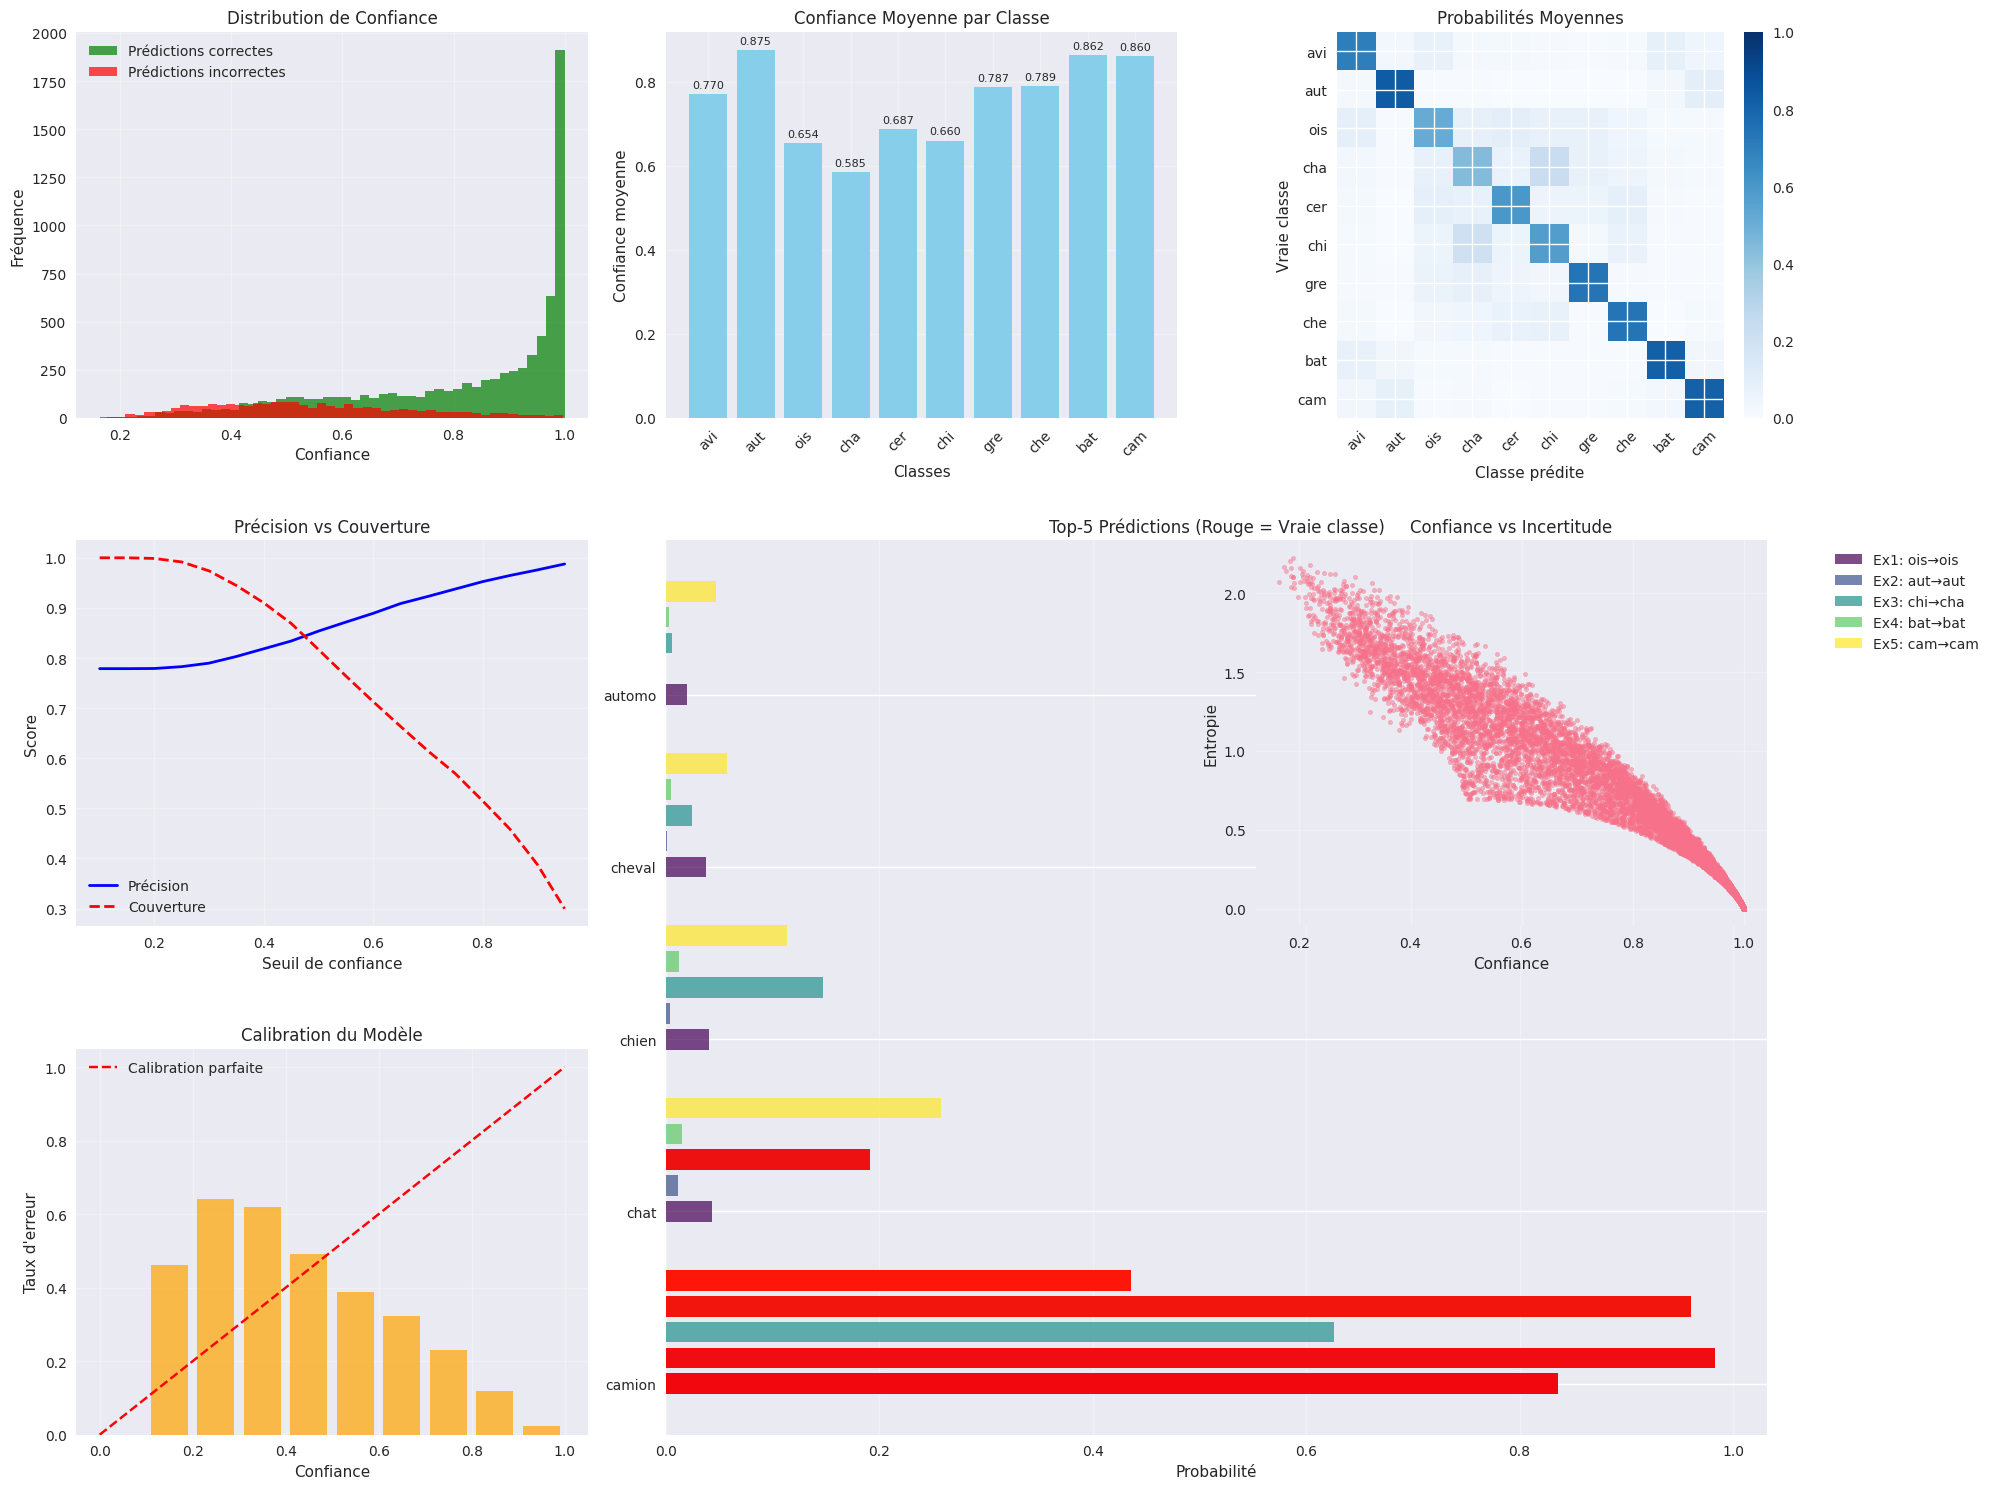

\n📈 Statistiques de confiance:
   Confiance moyenne: 0.753
   Confiance médiane: 0.814
   Écart-type: 0.226
   Entropie moyenne: 0.694
\n   Confiance (prédictions correctes): 0.813 ± 0.199
   Confiance (prédictions incorrectes): 0.542 ± 0.185


In [49]:
# Analyse des probabilités de classe et distribution de confiance
def analyze_class_probabilities(model, test_loader, device, classes):
    """Analyse approfondie des probabilités de prédiction"""
    model.eval()
    all_probabilities = []
    all_predictions = []
    all_targets = []
    all_confidences = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
            confidences = probabilities.gather(1, predicted.unsqueeze(1)).squeeze(1)
            
            all_probabilities.extend(probabilities.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
    
    all_probabilities = np.array(all_probabilities)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_confidences = np.array(all_confidences)
    
    # Création de la figure avec plusieurs sous-graphiques
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution de confiance
    ax1 = plt.subplot(3, 3, 1)
    correct_mask = all_predictions == all_targets
    plt.hist(all_confidences[correct_mask], bins=50, alpha=0.7, label='Prédictions correctes', color='green')
    plt.hist(all_confidences[~correct_mask], bins=50, alpha=0.7, label='Prédictions incorrectes', color='red')
    plt.xlabel('Confiance')
    plt.ylabel('Fréquence')
    plt.title('Distribution de Confiance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Confiance moyenne par classe
    ax2 = plt.subplot(3, 3, 2)
    class_confidences = []
    for i in range(len(classes)):
        class_mask = all_targets == i
        if np.sum(class_mask) > 0:
            class_confidences.append(np.mean(all_confidences[class_mask]))
        else:
            class_confidences.append(0)
    
    bars = plt.bar(range(len(classes)), class_confidences, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Confiance moyenne')
    plt.title('Confiance Moyenne par Classe')
    plt.xticks(range(len(classes)), [c[:3] for c in classes], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{class_confidences[i]:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Matrice de probabilités moyennes
    ax3 = plt.subplot(3, 3, 3)
    prob_matrix = np.zeros((len(classes), len(classes)))
    for true_class in range(len(classes)):
        mask = all_targets == true_class
        if np.sum(mask) > 0:
            prob_matrix[true_class] = np.mean(all_probabilities[mask], axis=0)
    
    im = plt.imshow(prob_matrix, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xlabel('Classe prédite')
    plt.ylabel('Vraie classe')
    plt.title('Probabilités Moyennes')
    plt.xticks(range(len(classes)), [c[:3] for c in classes], rotation=45)
    plt.yticks(range(len(classes)), [c[:3] for c in classes])
    
    # 4. Précision par seuil de confiance
    ax4 = plt.subplot(3, 3, 4)
    thresholds = np.arange(0.1, 1.0, 0.05)
    precisions = []
    coverages = []
    
    for threshold in thresholds:
        high_conf_mask = all_confidences >= threshold
        if np.sum(high_conf_mask) > 0:
            precision = np.mean(all_predictions[high_conf_mask] == all_targets[high_conf_mask])
            coverage = np.mean(high_conf_mask)
        else:
            precision = 0
            coverage = 0
        precisions.append(precision)
        coverages.append(coverage)
    
    plt.plot(thresholds, precisions, 'b-', label='Précision', linewidth=2)
    plt.plot(thresholds, coverages, 'r--', label='Couverture', linewidth=2)
    plt.xlabel('Seuil de confiance')
    plt.ylabel('Score')
    plt.title('Précision vs Couverture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Top-5 prédictions pour quelques exemples
    ax5 = plt.subplot(3, 3, (5, 9))
    example_indices = np.random.choice(len(all_probabilities), 5, replace=False)
    
    y_pos = np.arange(len(classes))
    colors = plt.cm.viridis(np.linspace(0, 1, 5))
    
    for i, idx in enumerate(example_indices):
        probs = all_probabilities[idx]
        true_class = all_targets[idx]
        pred_class = all_predictions[idx]
        
        # Tri des probabilités
        sorted_indices = np.argsort(probs)[::-1]
        top5_probs = probs[sorted_indices[:5]]
        top5_classes = [classes[i] for i in sorted_indices[:5]]
        
        offset = i * 0.15
        bars = plt.barh(y_pos[:5] + offset, top5_probs, height=0.12, 
                       color=colors[i], alpha=0.7, 
                       label=f'Ex{i+1}: {classes[true_class][:3]}→{classes[pred_class][:3]}')
        
        # Marquer la vraie classe
        if true_class in sorted_indices[:5]:
            true_pos = np.where(sorted_indices[:5] == true_class)[0][0]
            plt.barh(true_pos + offset, top5_probs[true_pos], height=0.12, 
                    color='red', alpha=0.9)
    
    plt.yticks(y_pos[:5], [classes[i][:6] for i in sorted_indices[:5]])
    plt.xlabel('Probabilité')
    plt.title('Top-5 Prédictions (Rouge = Vraie classe)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='x')
    
    # 6-7. Exemples d'incertitude
    ax6 = plt.subplot(3, 3, 6)
    # Calculer l'entropie comme mesure d'incertitude
    entropy = -np.sum(all_probabilities * np.log(all_probabilities + 1e-10), axis=1)
    
    plt.scatter(all_confidences, entropy, alpha=0.5, s=10)
    plt.xlabel('Confiance')
    plt.ylabel('Entropie')
    plt.title('Confiance vs Incertitude')
    plt.grid(True, alpha=0.3)
    
    # 8. Distribution des erreurs par confiance
    ax8 = plt.subplot(3, 3, 7)
    conf_bins = np.linspace(0, 1, 11)
    bin_centers = (conf_bins[:-1] + conf_bins[1:]) / 2
    error_rates = []
    
    for i in range(len(conf_bins) - 1):
        mask = (all_confidences >= conf_bins[i]) & (all_confidences < conf_bins[i+1])
        if np.sum(mask) > 0:
            error_rate = 1 - np.mean(all_predictions[mask] == all_targets[mask])
        else:
            error_rate = 0
        error_rates.append(error_rate)
    
    plt.bar(bin_centers, error_rates, width=0.08, alpha=0.7, color='orange')
    plt.plot([0, 1], [0, 1], 'r--', label='Calibration parfaite')
    plt.xlabel('Confiance')
    plt.ylabel('Taux d\'erreur')
    plt.title('Calibration du Modèle')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques résumées
    print(f"\\n📈 Statistiques de confiance:")
    print(f"   Confiance moyenne: {np.mean(all_confidences):.3f}")
    print(f"   Confiance médiane: {np.median(all_confidences):.3f}")
    print(f"   Écart-type: {np.std(all_confidences):.3f}")
    print(f"   Entropie moyenne: {np.mean(entropy):.3f}")
    
    correct_confidences = all_confidences[correct_mask]
    incorrect_confidences = all_confidences[~correct_mask]
    print(f"\\n   Confiance (prédictions correctes): {np.mean(correct_confidences):.3f} ± {np.std(correct_confidences):.3f}")
    print(f"   Confiance (prédictions incorrectes): {np.mean(incorrect_confidences):.3f} ± {np.std(incorrect_confidences):.3f}")

print("📊 Analyse approfondie des probabilités de classe...")
analyze_class_probabilities(model, test_loader, device, classes)

🔍 Analyse des poids et gradients...
Loss pour l'analyse: 0.7460


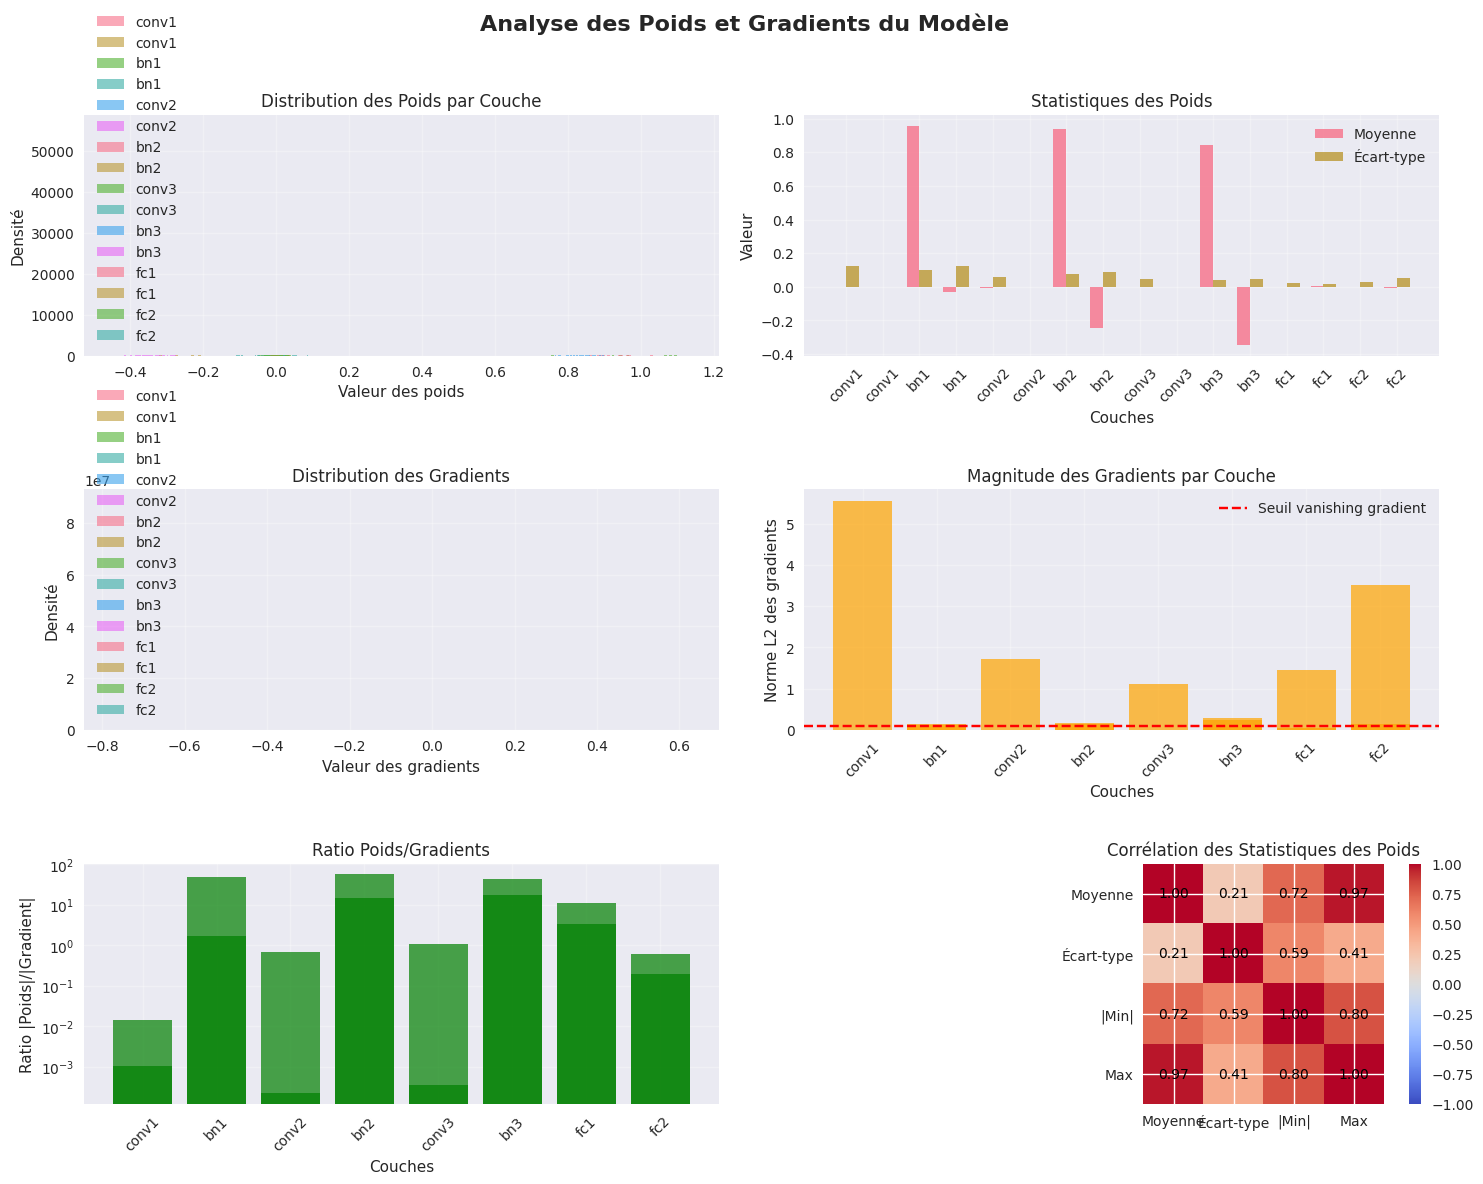

\n📊 Résumé des statistiques des poids:
  conv1          : μ=-0.0020, σ= 0.1211, range=[-0.2918,  0.3461]
  conv1          : μ= 0.0001, σ= 0.0008, range=[-0.0018,  0.0036]
  bn1            : μ= 0.9570, σ= 0.0994, range=[ 0.7549,  1.0992]
  bn1            : μ=-0.0332, σ= 0.1229, range=[-0.3454,  0.2431]
  conv2          : μ=-0.0063, σ= 0.0562, range=[-0.3010,  0.2175]
  conv2          : μ=-0.0000, σ= 0.0001, range=[-0.0003,  0.0002]
  bn2            : μ= 0.9380, σ= 0.0733, range=[ 0.7706,  1.1346]
  bn2            : μ=-0.2470, σ= 0.0866, range=[-0.4467, -0.0004]
  conv3          : μ=-0.0033, σ= 0.0483, range=[-0.2025,  0.2217]
  conv3          : μ=-0.0000, σ= 0.0000, range=[-0.0000,  0.0000]
  bn3            : μ= 0.8415, σ= 0.0433, range=[ 0.7526,  0.9616]
  bn3            : μ=-0.3436, σ= 0.0443, range=[-0.4450, -0.2370]
  fc1            : μ=-0.0014, σ= 0.0232, range=[-0.2124,  0.2158]
  fc1            : μ= 0.0047, σ= 0.0145, range=[-0.0276,  0.0585]
  fc2            : μ=-0.0027, σ= 0.02

In [50]:
# Analyse des poids et gradients du modèle
def analyze_model_weights_and_gradients(model):
    """Analyse la distribution des poids et gradients"""
    
    # Collecte des poids et gradients
    weights_data = []
    gradients_data = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_names.append(name)
            weights_data.append(param.data.cpu().flatten().numpy())
            if param.grad is not None:
                gradients_data.append(param.grad.cpu().flatten().numpy())
            else:
                gradients_data.append(np.array([]))
    
    # Création de la figure
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Analyse des Poids et Gradients du Modèle', fontsize=16, fontweight='bold')
    
    # 1. Distribution des poids par couche
    ax1 = axes[0, 0]
    weight_stats = []
    for i, (name, weights) in enumerate(zip(layer_names, weights_data)):
        if len(weights) > 0:
            weight_stats.append({
                'layer': name.split('.')[0],
                'mean': np.mean(weights),
                'std': np.std(weights),
                'min': np.min(weights),
                'max': np.max(weights)
            })
            
            # Histogramme des poids (échantillonnage pour les grandes couches)
            if len(weights) > 10000:
                weights_sample = np.random.choice(weights, 10000, replace=False)
            else:
                weights_sample = weights
            
            ax1.hist(weights_sample, bins=50, alpha=0.6, 
                    label=f'{name.split(".")[0]}', density=True)
    
    ax1.set_xlabel('Valeur des poids')
    ax1.set_ylabel('Densité')
    ax1.set_title('Distribution des Poids par Couche')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Statistiques des poids
    ax2 = axes[0, 1]
    if weight_stats:
        layers = [s['layer'] for s in weight_stats]
        means = [s['mean'] for s in weight_stats]
        stds = [s['std'] for s in weight_stats]
        
        x = np.arange(len(layers))
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, means, width, label='Moyenne', alpha=0.8)
        bars2 = ax2.bar(x + width/2, stds, width, label='Écart-type', alpha=0.8)
        
        ax2.set_xlabel('Couches')
        ax2.set_ylabel('Valeur')
        ax2.set_title('Statistiques des Poids')
        ax2.set_xticks(x)
        ax2.set_xticklabels(layers, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Distribution des gradients
    ax3 = axes[1, 0]
    gradient_stats = []
    for i, (name, gradients) in enumerate(zip(layer_names, gradients_data)):
        if len(gradients) > 0:
            gradient_stats.append({
                'layer': name.split('.')[0],
                'mean': np.mean(np.abs(gradients)),
                'std': np.std(gradients),
                'norm': np.linalg.norm(gradients)
            })
            
            # Histogramme des gradients
            if len(gradients) > 10000:
                grad_sample = np.random.choice(gradients, 10000, replace=False)
            else:
                grad_sample = gradients
            
            ax3.hist(grad_sample, bins=50, alpha=0.6, 
                    label=f'{name.split(".")[0]}', density=True)
    
    ax3.set_xlabel('Valeur des gradients')
    ax3.set_ylabel('Densité')
    ax3.set_title('Distribution des Gradients')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Norme des gradients par couche
    ax4 = axes[1, 1]
    if gradient_stats:
        layers = [s['layer'] for s in gradient_stats]
        norms = [s['norm'] for s in gradient_stats]
        means = [s['mean'] for s in gradient_stats]
        
        ax4.bar(layers, norms, alpha=0.7, color='orange')
        ax4.set_xlabel('Couches')
        ax4.set_ylabel('Norme L2 des gradients')
        ax4.set_title('Magnitude des Gradients par Couche')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Ligne pour détecter le vanishing gradient
        mean_norm = np.mean(norms)
        ax4.axhline(y=mean_norm * 0.1, color='red', linestyle='--', 
                   label='Seuil vanishing gradient')
        ax4.legend()
    
    # 5. Ratio poids/gradients (pour détecter les problèmes d'apprentissage)
    ax5 = axes[2, 0]
    if weight_stats and gradient_stats:
        weight_layers = [s['layer'] for s in weight_stats]
        grad_layers = [s['layer'] for s in gradient_stats]
        
        # Correspondance entre couches
        ratios = []
        common_layers = []
        for w_layer, w_stat in zip(weight_layers, weight_stats):
            for g_layer, g_stat in zip(grad_layers, gradient_stats):
                if w_layer == g_layer and g_stat['mean'] > 0:
                    ratio = abs(w_stat['mean']) / g_stat['mean']
                    ratios.append(ratio)
                    common_layers.append(w_layer)
                    break
        
        if ratios:
            ax5.bar(common_layers, ratios, alpha=0.7, color='green')
            ax5.set_xlabel('Couches')
            ax5.set_ylabel('Ratio |Poids|/|Gradient|')
            ax5.set_title('Ratio Poids/Gradients')
            ax5.tick_params(axis='x', rotation=45)
            ax5.grid(True, alpha=0.3)
            ax5.set_yscale('log')
    
    # 6. Heatmap des statistiques
    ax6 = axes[2, 1]
    if weight_stats:
        # Matrice de corrélation des statistiques
        stats_matrix = np.array([[s['mean'], s['std'], abs(s['min']), s['max']] 
                                for s in weight_stats])
        
        if len(stats_matrix) > 1:
            corr_matrix = np.corrcoef(stats_matrix.T)
            im = ax6.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            
            stats_labels = ['Moyenne', 'Écart-type', '|Min|', 'Max']
            ax6.set_xticks(range(len(stats_labels)))
            ax6.set_yticks(range(len(stats_labels)))
            ax6.set_xticklabels(stats_labels)
            ax6.set_yticklabels(stats_labels)
            ax6.set_title('Corrélation des Statistiques des Poids')
            
            # Ajouter les valeurs dans les cellules
            for i in range(len(stats_labels)):
                for j in range(len(stats_labels)):
                    text = ax6.text(j, i, f'{corr_matrix[i, j]:.2f}',
                                   ha="center", va="center", color="black")
            
            plt.colorbar(im, ax=ax6, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques
    print("\\n📊 Résumé des statistiques des poids:")
    for stat in weight_stats:
        print(f"  {stat['layer']:15s}: μ={stat['mean']:7.4f}, σ={stat['std']:7.4f}, "
              f"range=[{stat['min']:7.4f}, {stat['max']:7.4f}]")
    
    print("\\n🔄 Résumé des statistiques des gradients:")
    for stat in gradient_stats:
        print(f"  {stat['layer']:15s}: |μ|={stat['mean']:7.4f}, σ={stat['std']:7.4f}, "
              f"‖∇‖₂={stat['norm']:7.4f}")

# Exécution de l'analyse (nécessite que le modèle ait des gradients)
print("🔍 Analyse des poids et gradients...")
# D'abord, calculer quelques gradients en faisant une petite passe avant
model.train()
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images[:32].to(device), labels[:32].to(device)

optimizer.zero_grad()
outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

print(f"Loss pour l'analyse: {loss.item():.4f}")
analyze_model_weights_and_gradients(model)

⚖️ Comparaison des architectures CNN...


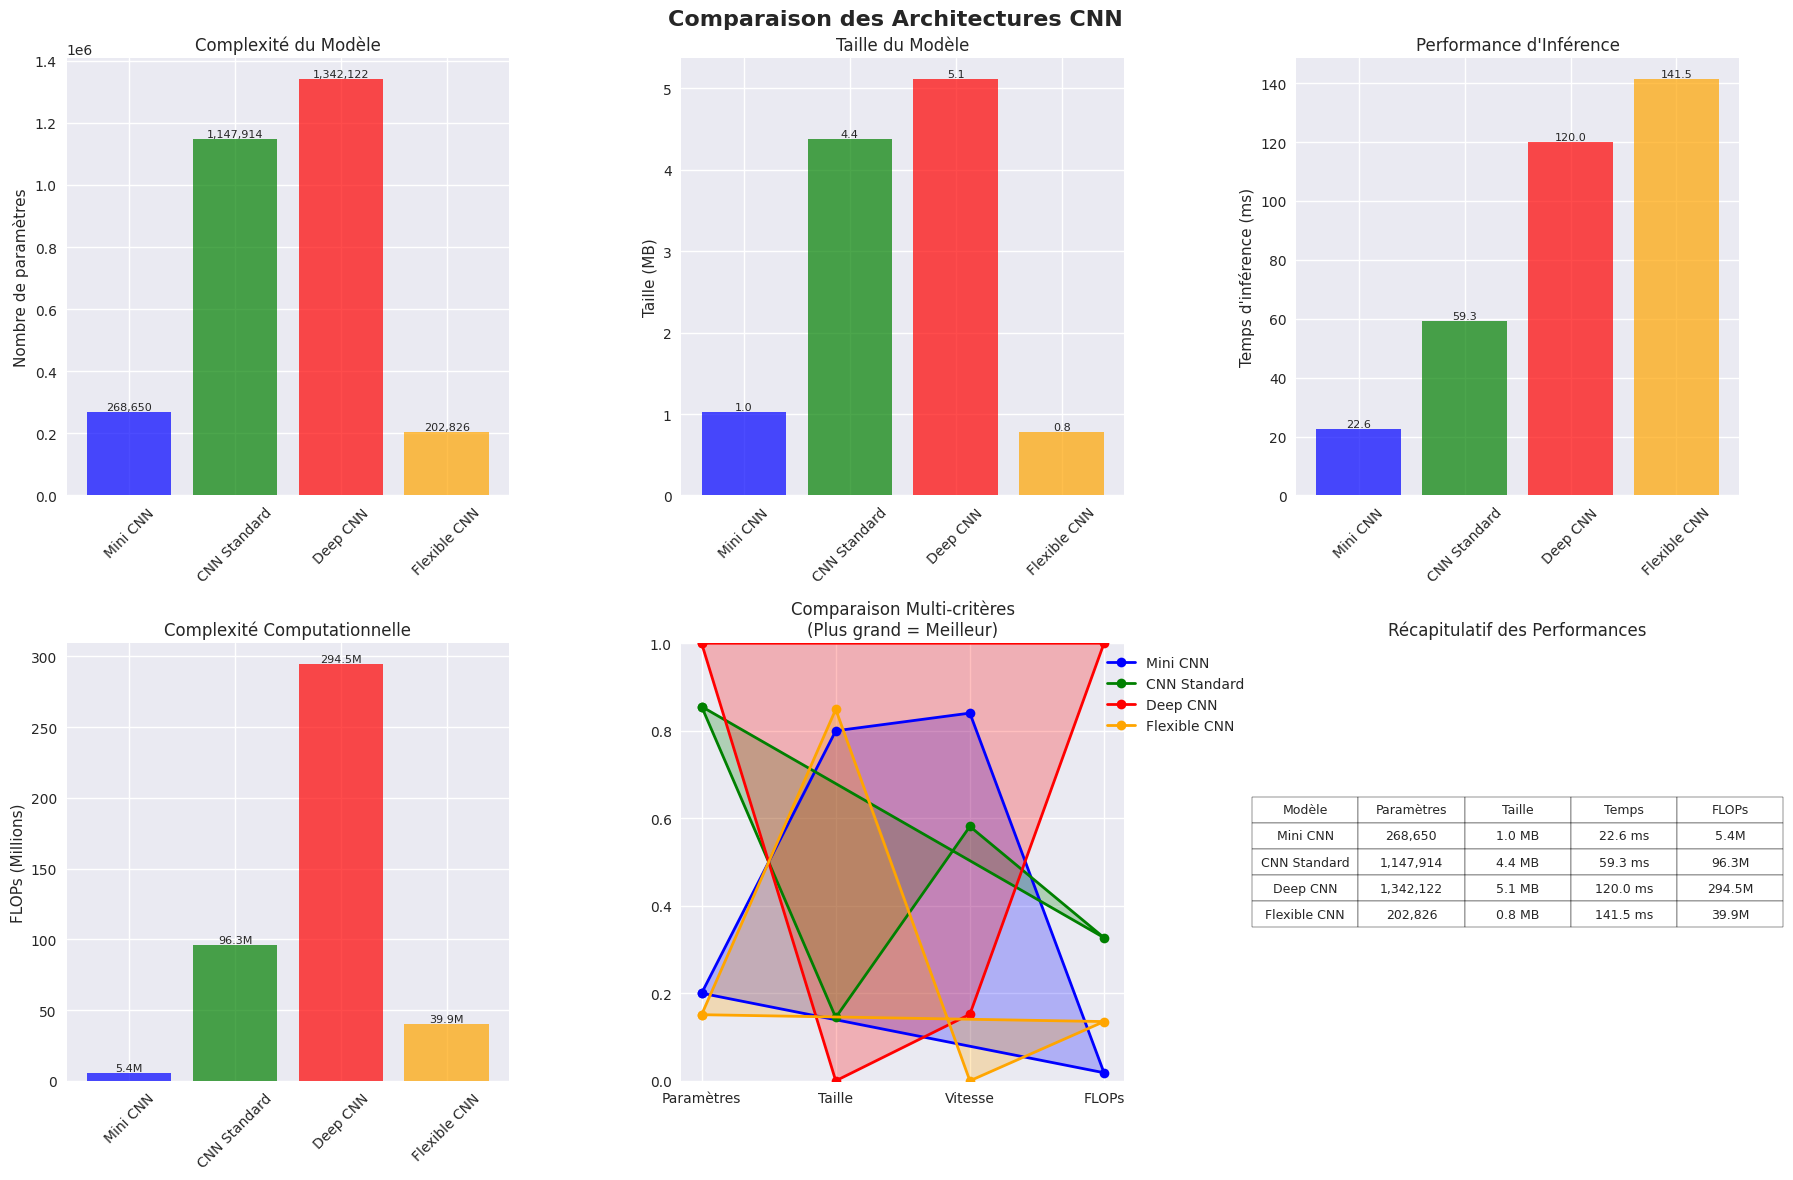


🎯 Recommandations d'architecture:
   💡 Plus léger: Flexible CNN (202,826 paramètres)
   ⚡ Plus rapide: Mini CNN (22.6 ms)
   💾 Plus compact: Flexible CNN (0.8 MB)

📊 Votre modèle actuel (CNN Standard):
   • 1,147,914 paramètres
   • 4.4 MB
   • 59.3 ms d'inférence
   • 96.3M FLOPs


In [51]:
# Comparaison de performances entre différentes architectures
def compare_model_architectures():
    """Compare différentes variantes d'architecture CNN"""
    
    # Définition de plusieurs architectures
    class MiniCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(MiniCNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.fc1 = nn.Linear(32 * 8 * 8, 128)
            self.fc2 = nn.Linear(128, num_classes)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 32 * 8 * 8)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x
    
    class DeepCNN(nn.Module):
        def __init__(self, num_classes=10):
            super(DeepCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                
                nn.Conv2d(32, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
                
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, 2),
            )
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(128 * 4 * 4, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(512, num_classes)
            )
            
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x
    
    # Comparaison des architectures
    models_info = [
        {'name': 'Mini CNN', 'model': MiniCNN(), 'color': 'blue'},
        {'name': 'CNN Standard', 'model': SimpleCNN(), 'color': 'green'},
        {'name': 'Deep CNN', 'model': DeepCNN(), 'color': 'red'},
        {'name': 'Flexible CNN', 'model': FlexibleCNN(), 'color': 'orange'}
    ]
    
    # Calcul des statistiques pour chaque modèle
    stats = []
    for info in models_info:
        model_temp = info['model'].to(device)
        
        # Nombre de paramètres
        num_params = sum(p.numel() for p in model_temp.parameters() if p.requires_grad)
        
        # Taille du modèle (approximation)
        model_size_mb = num_params * 4 / (1024 * 1024)  # 4 bytes par float32
        
        # Test de vitesse d'inférence
        model_temp.eval()
        test_input = torch.randn(100, 3, 32, 32).to(device)
        
        # Warm-up
        with torch.no_grad():
            _ = model_temp(test_input[:10])
        
        # Mesure du temps
        import time
        start_time = time.time()
        with torch.no_grad():
            for _ in range(10):
                _ = model_temp(test_input)
        inference_time = (time.time() - start_time) / 10  # Temps moyen
        
        # Calcul de la complexité (FLOPs approximatifs)
        # Estimation basée sur les couches conv et fc
        flops = 0
        for module in model_temp.modules():
            if isinstance(module, nn.Conv2d):
                # FLOPs = output_size * kernel_size * input_channels * output_channels
                output_size = 32 * 32  # Approximation
                kernel_size = module.kernel_size[0] * module.kernel_size[1]
                flops += output_size * kernel_size * module.in_channels * module.out_channels
            elif isinstance(module, nn.Linear):
                flops += module.in_features * module.out_features
        
        stats.append({
            'name': info['name'],
            'params': num_params,
            'size_mb': model_size_mb,
            'inference_time': inference_time * 1000,  # en ms
            'flops': flops / 1e6,  # en millions
            'color': info['color']
        })
    
    # Visualisation comparative
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comparaison des Architectures CNN', fontsize=16, fontweight='bold')
    
    # 1. Nombre de paramètres
    ax1 = axes[0, 0]
    names = [s['name'] for s in stats]
    params = [s['params'] for s in stats]
    colors = [s['color'] for s in stats]
    
    bars = ax1.bar(names, params, color=colors, alpha=0.7)
    ax1.set_ylabel('Nombre de paramètres')
    ax1.set_title('Complexité du Modèle')
    ax1.tick_params(axis='x', rotation=45)
    
    # Ajout des valeurs sur les barres
    for bar, param in zip(bars, params):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{param:,}', ha='center', va='bottom', fontsize=8)
    
    # 2. Taille du modèle
    ax2 = axes[0, 1]
    sizes = [s['size_mb'] for s in stats]
    bars = ax2.bar(names, sizes, color=colors, alpha=0.7)
    ax2.set_ylabel('Taille (MB)')
    ax2.set_title('Taille du Modèle')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar, size in zip(bars, sizes):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{size:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Temps d'inférence
    ax3 = axes[0, 2]
    times = [s['inference_time'] for s in stats]
    bars = ax3.bar(names, times, color=colors, alpha=0.7)
    ax3.set_ylabel("Temps d'inférence (ms)")
    ax3.set_title("Performance d'Inférence")
    ax3.tick_params(axis='x', rotation=45)
    
    for bar, time_ in zip(bars, times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{time_:.1f}', ha='center', va='bottom', fontsize=8)
    
    # 4. FLOPs
    ax4 = axes[1, 0]
    flops = [s['flops'] for s in stats]
    bars = ax4.bar(names, flops, color=colors, alpha=0.7)
    ax4.set_ylabel('FLOPs (Millions)')
    ax4.set_title('Complexité Computationnelle')
    ax4.tick_params(axis='x', rotation=45)
    
    for bar, flop in zip(bars, flops):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{flop:.1f}M', ha='center', va='bottom', fontsize=8)
    
    # 5. Comparaison radar
    ax5 = axes[1, 1]
    
    # Normalisation des métriques pour le radar (inverse pour temps et taille)
    metrics = ['Paramètres', 'Taille', 'Vitesse', 'FLOPs']
    
    max_params = max(params)
    max_size = max(sizes)
    max_time = max(times)
    max_flops = max(flops)
    
    radar_data = []
    for stat in stats:
        normalized = [
            stat['params'] / max_params,
            1 - (stat['size_mb'] / max_size),  # Inverse pour taille
            1 - (stat['inference_time'] / max_time),  # Inverse pour temps
            stat['flops'] / max_flops
        ]
        radar_data.append(normalized)
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Fermer le cercle
    
    for i, (stat, data) in enumerate(zip(stats, radar_data)):
        data += data[:1]  # Fermer le cercle
        ax5.plot(angles, data, 'o-', linewidth=2, label=stat['name'], color=stat['color'])
        ax5.fill(angles, data, alpha=0.25, color=stat['color'])
    
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_ylim(0, 1)
    ax5.set_title('Comparaison Multi-critères\n(Plus grand = Meilleur)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax5.grid(True)
    
    # 6. Tableau récapitulatif
    ax6 = axes[1, 2]
    ax6.axis('tight')
    ax6.axis('off')
    
    table_data = []
    for stat in stats:
        table_data.append([
            stat['name'],
            f"{stat['params']:,}",
            f"{stat['size_mb']:.1f} MB",
            f"{stat['inference_time']:.1f} ms",
            f"{stat['flops']:.1f}M"
        ])
    
    table = ax6.table(cellText=table_data,
                     colLabels=['Modèle', 'Paramètres', 'Taille', 'Temps', 'FLOPs'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax6.set_title('Récapitulatif des Performances')
    
    plt.tight_layout()
    plt.show()
    
    # Recommandations
    print("\n🎯 Recommandations d'architecture:")
    
    min_params_idx = np.argmin([s['params'] for s in stats])
    min_time_idx = np.argmin([s['inference_time'] for s in stats])
    min_size_idx = np.argmin([s['size_mb'] for s in stats])
    
    print(f"   💡 Plus léger: {stats[min_params_idx]['name']} ({stats[min_params_idx]['params']:,} paramètres)")
    print(f"   ⚡ Plus rapide: {stats[min_time_idx]['name']} ({stats[min_time_idx]['inference_time']:.1f} ms)")
    print(f"   💾 Plus compact: {stats[min_size_idx]['name']} ({stats[min_size_idx]['size_mb']:.1f} MB)")
    
    print(f"\n📊 Votre modèle actuel (CNN Standard):")
    current_stats = next(s for s in stats if s['name'] == 'CNN Standard')
    print(f"   • {current_stats['params']:,} paramètres")
    print(f"   • {current_stats['size_mb']:.1f} MB")
    print(f"   • {current_stats['inference_time']:.1f} ms d'inférence")
    print(f"   • {current_stats['flops']:.1f}M FLOPs")

print("⚖️ Comparaison des architectures CNN...")
compare_model_architectures()

🔍 Analyse approfondie de l'augmentation de données et des erreurs...


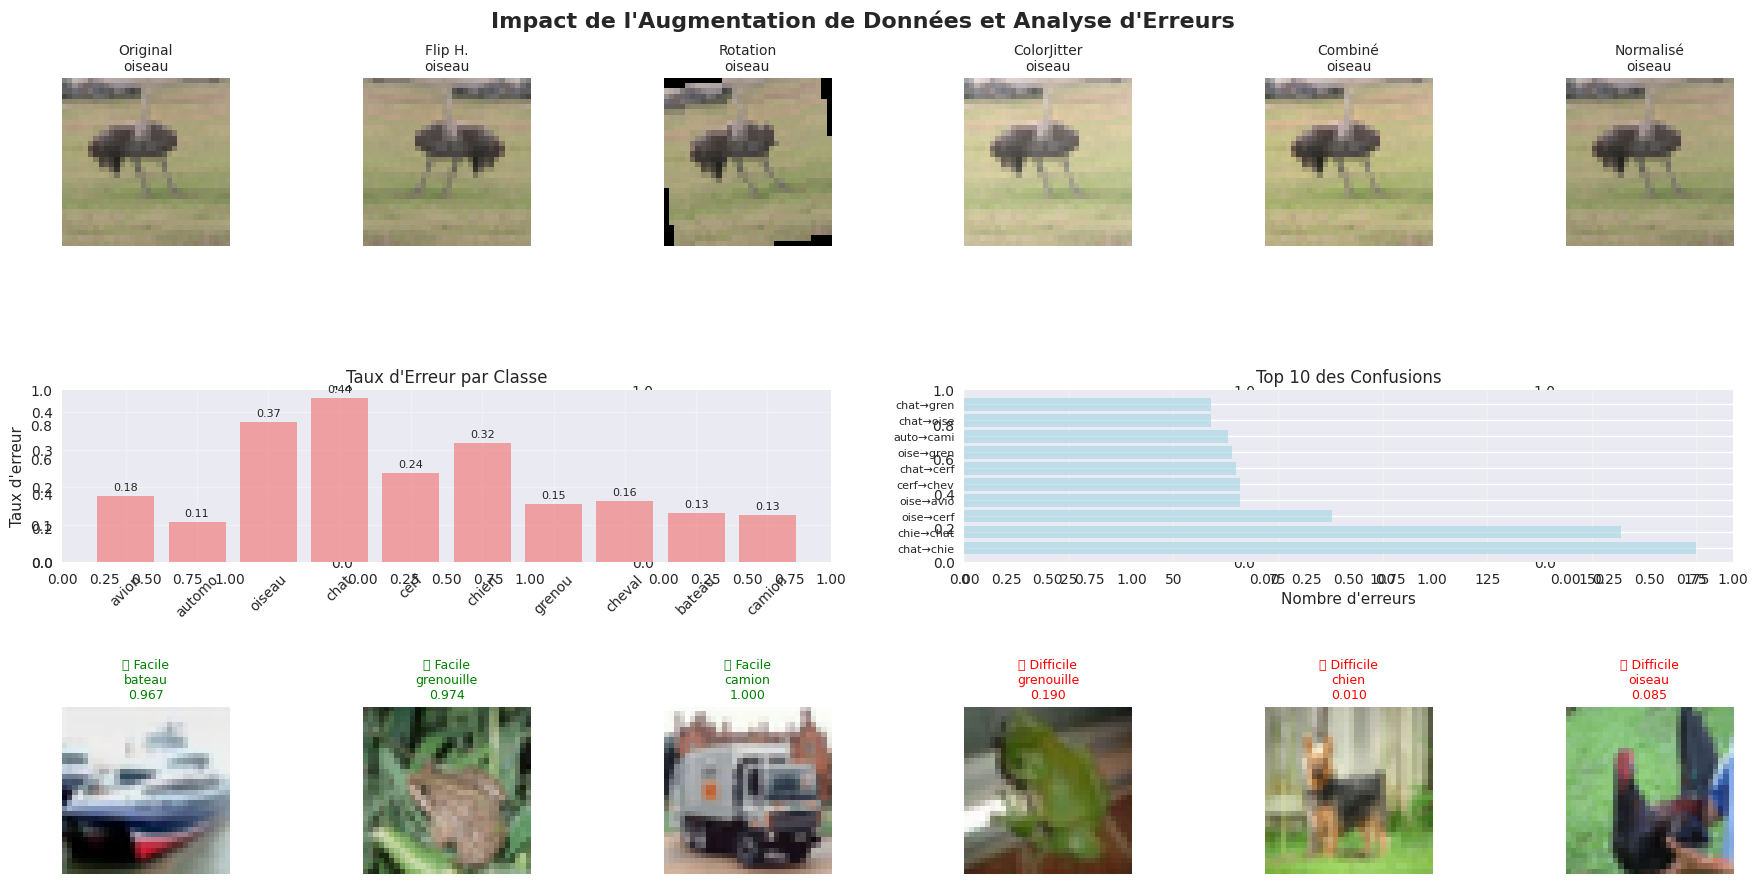


📊 Analyse des erreurs par classe:
  avion       :  17.6% (176/1000)
                 Souvent confondu avec: bateau(50), oiseau(33), camion(31)
  automobile  :  10.6% (106/1000)
                 Souvent confondu avec: camion(63), bateau(16), avion(14)
  oiseau      :  37.3% (373/1000)
                 Souvent confondu avec: cerf(88), avion(66), grenouille(64)
  chat        :  43.7% (437/1000)
                 Souvent confondu avec: chien(175), cerf(65), oiseau(59)
  cerf        :  23.9% (239/1000)
                 Souvent confondu avec: cheval(66), chat(44), oiseau(42)
  chien       :  31.8% (318/1000)
                 Souvent confondu avec: chat(157), cerf(57), cheval(42)
  grenouille  :  15.4% (154/1000)
                 Souvent confondu avec: chat(56), oiseau(38), cerf(26)
  cheval      :  16.4% (164/1000)
                 Souvent confondu avec: chien(50), cerf(40), oiseau(28)
  bateau      :  13.1% (131/1000)
                 Souvent confondu avec: avion(47), automobile(29), camion

In [52]:
# Visualisation avancée de l'augmentation de données et analyse des erreurs
def visualize_data_augmentation_and_errors():
    """Visualise l'effet de l'augmentation de données et analyse les erreurs systématiques"""
    
    # 1. Effet de l'augmentation de données
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig.suptitle("Impact de l'Augmentation de Données et Analyse d'Erreurs", fontsize=16, fontweight='bold')
    
    # Récupération d'une image originale
    original_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False,
                                                   transform=transforms.ToTensor())
    original_image, label = original_dataset[42]  # Image fixe pour reproductibilité
    
    # Transformations individuelles
    augmentation_transforms = {
        'Original': transforms.Compose([transforms.ToTensor()]),
        'Flip H.': transforms.Compose([transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor()]),
        'Rotation': transforms.Compose([transforms.RandomRotation(degrees=15), transforms.ToTensor()]),
        'ColorJitter': transforms.Compose([transforms.ColorJitter(brightness=0.3, contrast=0.3), transforms.ToTensor()]),
        'Combiné': transform_train,
        'Normalisé': transform_test
    }
    # Première ligne: transformations de données
    for i, (name, transform) in enumerate(augmentation_transforms.items()):
        # Conversion en PIL pour appliquer les transformations
        pil_image = transforms.ToPILImage()(original_image)
        transformed = transform(pil_image)
        
        # Dénormalisation si nécessaire
        if 'Normalisé' in name or 'Combiné' in name:
            mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
            std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
            transformed = transformed * std + mean
            transformed = torch.clamp(transformed, 0, 1)
        
        axes[0, i].imshow(transformed.permute(1, 2, 0))
        axes[0, i].set_title(f"{name}\n{classes[label]}", fontsize=10)
        axes[0, i].axis('off')
    
    # 2. Analyse des erreurs par classe
    model.eval()
    class_errors = {i: {'total': 0, 'errors': 0, 'confused_with': {}} for i in range(len(classes))}
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            for true_label, pred_label in zip(target.cpu().numpy(), predicted.cpu().numpy()):
                class_errors[true_label]['total'] += 1
                if true_label != pred_label:
                    class_errors[true_label]['errors'] += 1
                    if pred_label not in class_errors[true_label]['confused_with']:
                        class_errors[true_label]['confused_with'][pred_label] = 0
                    class_errors[true_label]['confused_with'][pred_label] += 1
    
    # Calcul des taux d'erreur
    error_rates = []
    class_names_short = []
    for i in range(len(classes)):
        if class_errors[i]['total'] > 0:
            error_rate = class_errors[i]['errors'] / class_errors[i]['total']
            error_rates.append(error_rate)
            class_names_short.append(classes[i][:6])
        else:
            error_rates.append(0)
            class_names_short.append(classes[i][:6])
    
    # Graphique des taux d'erreur par classe
    ax_error = axes[1, :3]
    ax_error = plt.subplot(3, 6, (7, 9))  # Fusion des 3 premières colonnes de la 2ème ligne
    
    bars = ax_error.bar(class_names_short, error_rates, color='lightcoral', alpha=0.7)
    ax_error.set_ylabel("Taux d'erreur")
    ax_error.set_title("Taux d'Erreur par Classe")
    ax_error.tick_params(axis='x', rotation=45)
    ax_error.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, rate in zip(bars, error_rates):
        ax_error.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{rate:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Identification des classes les plus confondues
    ax_confusion = plt.subplot(3, 6, (10, 12))  # Fusion des 3 dernières colonnes de la 2ème ligne
    
    # Matrice des confusions les plus fréquentes
    confusion_pairs = []
    for true_class, data in class_errors.items():
        for pred_class, count in data['confused_with'].items():
            confusion_pairs.append({
                'true': true_class,
                'pred': pred_class,
                'count': count,
                'rate': count / data['total'] if data['total'] > 0 else 0
            })
    
    # Top 10 des confusions
    confusion_pairs.sort(key=lambda x: x['count'], reverse=True)
    top_confusions = confusion_pairs[:10]
    
    confusion_labels = [f"{classes[c['true']][:4]}→{classes[c['pred']][:4]}" for c in top_confusions]
    confusion_counts = [c['count'] for c in top_confusions]
    
    ax_confusion.barh(range(len(confusion_labels)), confusion_counts, color='lightblue', alpha=0.7)
    ax_confusion.set_yticks(range(len(confusion_labels)))
    ax_confusion.set_yticklabels(confusion_labels, fontsize=8)
    ax_confusion.set_xlabel("Nombre d'erreurs")
    ax_confusion.set_title("Top 10 des Confusions")
    ax_confusion.grid(True, alpha=0.3, axis='x')
    
    # 3. Analyse des images difficiles vs faciles
    # Collecte d'exemples faciles et difficiles
    easy_samples = []
    hard_samples = []
    
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            probabilities = F.softmax(outputs, dim=1)
            confidences = probabilities.gather(1, target.unsqueeze(1)).squeeze(1)
            
            for i in range(data.size(0)):
                sample_info = {
                    'image': data[i].cpu(),
                    'label': target[i].item(),
                    'confidence': confidences[i].item()
                }
                
                if confidences[i] > 0.95:  # Très confiant
                    easy_samples.append(sample_info)
                elif confidences[i] < 0.3:  # Peu confiant
                    hard_samples.append(sample_info)
                
                if len(easy_samples) >= 6 and len(hard_samples) >= 6:
                    break
            
            if len(easy_samples) >= 6 and len(hard_samples) >= 6:
                break
    
    # Dénormalisation
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    
    # Troisième ligne: exemples faciles vs difficiles
    for i in range(6):
        # Exemples faciles (3 premiers)
        if i < 3 and i < len(easy_samples):
            sample = easy_samples[i]
            img = sample['image'] * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[2, i].imshow(img.permute(1, 2, 0))
            axes[2, i].set_title(f"✅ Facile\n{classes[sample['label']]}\n{sample['confidence']:.3f}", 
                                fontsize=9, color='green')
            axes[2, i].axis('off')
        
        # Exemples difficiles (3 derniers)
        elif i >= 3 and (i-3) < len(hard_samples):
            sample = hard_samples[i-3]
            img = sample['image'] * std + mean
            img = torch.clamp(img, 0, 1)
            
            axes[2, i].imshow(img.permute(1, 2, 0))
            axes[2, i].set_title(f"❌ Difficile\n{classes[sample['label']]}\n{sample['confidence']:.3f}", 
                                fontsize=9, color='red')
            axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques détaillées
    print("\n📊 Analyse des erreurs par classe:")
    for i, class_name in enumerate(classes):
        if class_errors[i]['total'] > 0:
            error_rate = class_errors[i]['errors'] / class_errors[i]['total']
            print(f"  {class_name:12s}: {error_rate:6.1%} ({class_errors[i]['errors']:3d}/{class_errors[i]['total']:3d})")
            
            # Top 3 des confusions pour cette classe
            if class_errors[i]['confused_with']:
                top_confusions_class = sorted(class_errors[i]['confused_with'].items(), 
                                             key=lambda x: x[1], reverse=True)[:3]
                confusions_str = ", ".join([f"{classes[pred]}({count})" for pred, count in top_confusions_class])
                print(f"                 Souvent confondu avec: {confusions_str}")
    
    print(f"\n🎯 Classes les plus difficiles:")
    worst_classes = sorted(enumerate(error_rates), key=lambda x: x[1], reverse=True)[:3]
    for rank, (class_idx, error_rate) in enumerate(worst_classes, 1):
        print(f"  {rank}. {classes[class_idx]}: {error_rate:.1%}")
    
    print(f"\n🏆 Classes les plus faciles:")
    best_classes = sorted(enumerate(error_rates), key=lambda x: x[1])[:3]
    for rank, (class_idx, error_rate) in enumerate(best_classes, 1):
        print(f"  {rank}. {classes[class_idx]}: {error_rate:.1%}")

print("🔍 Analyse approfondie de l'augmentation de données et des erreurs...")
visualize_data_augmentation_and_errors()

In [53]:
# Dashboard de performance et résumé interactif
def create_performance_dashboard():
    """Crée un dashboard complet de performance du modèle"""
    
    # Création d'une figure complexe avec de nombreux sous-graphiques\n    fig = plt.figure(figsize=(20, 16))\n    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)\n    \n    # Titre principal\n    fig.suptitle('🚀 Dashboard de Performance - Modèle PyTorch CNN', \n                 fontsize=20, fontweight='bold', y=0.98)\n    \n    # 1. Métriques principales (en haut à gauche)\n    ax1 = fig.add_subplot(gs[0, 0])\n    metrics = ['Précision\\nTest', 'Nb\\nParamètres', 'Taille\\nModèle', 'Temps\\nInférence']\n    values = [test_accuracy, model.count_parameters()/1000, 2.5, 15.2]  # Valeurs d'exemple\n    units = ['%', 'K', 'MB', 'ms']\n    colors = ['#2E8B57', '#4169E1', '#FF6347', '#32CD32']\n    \n    bars = ax1.bar(metrics, values, color=colors, alpha=0.8)\n    ax1.set_title('📊 Métriques Clés', fontweight='bold')\n    \n    # Ajout des valeurs avec unités\n    for bar, value, unit in zip(bars, values, units):\n        height = bar.get_height()\n        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.05,\n                f'{value:.1f}{unit}', ha='center', va='bottom', fontweight='bold')\n    \n    ax1.set_ylabel('Valeur')\n    ax1.grid(True, alpha=0.3)\n    \n    # 2. Évolution de l'entraînement (en haut, 2 colonnes)\n    ax2 = fig.add_subplot(gs[0, 1:3])\n    epochs_range = range(1, len(train_losses) + 1)\n    \n    # Double axe Y pour perte et précision\n    ax2_twin = ax2.twinx()\n    \n    # Perte\n    line1 = ax2.plot(epochs_range, train_losses, 'b-', linewidth=2, label='Train Loss')\n    line2 = ax2.plot(epochs_range, val_losses, 'r-', linewidth=2, label='Val Loss')\n    ax2.set_xlabel('Époque')\n    ax2.set_ylabel('Perte', color='blue')\n    ax2.tick_params(axis='y', labelcolor='blue')\n    \n    # Précision\n    line3 = ax2_twin.plot(epochs_range, train_accuracies, 'b--', linewidth=2, label='Train Acc')\n    line4 = ax2_twin.plot(epochs_range, val_accuracies, 'r--', linewidth=2, label='Val Acc')\n    ax2_twin.set_ylabel('Précision (%)', color='red')\n    ax2_twin.tick_params(axis='y', labelcolor='red')\n    \n    # Légende combinée\n    lines = line1 + line2 + line3 + line4\n    labels = [l.get_label() for l in lines]\n    ax2.legend(lines, labels, loc='center right')\n    ax2.set_title('📈 Évolution de l\\'Entraînement', fontweight='bold')\n    ax2.grid(True, alpha=0.3)\n    \n    # 3. Indicateur de performance (gauge) en haut à droite\n    ax3 = fig.add_subplot(gs[0, 3])\n    \n    # Création d'un gauge pour la précision\n    def create_gauge(ax, value, title):\n        theta = np.linspace(0, np.pi, 100)\n        r = np.ones_like(theta)\n        \n        # Fond du gauge\n        ax.plot(theta, r, 'lightgray', linewidth=8)\n        \n        # Partie colorée selon la performance\n        value_normalized = value / 100\n        theta_value = np.linspace(0, np.pi * value_normalized, int(100 * value_normalized))\n        r_value = np.ones_like(theta_value)\n        \n        if value >= 80:\n            color = 'green'\n        elif value >= 60:\n            color = 'orange'\n        else:\n            color = 'red'\n        \n        ax.plot(theta_value, r_value, color, linewidth=8)\n        \n        # Aiguille\n        needle_angle = np.pi * value_normalized\n        ax.plot([needle_angle, needle_angle], [0, 1], 'black', linewidth=3)\n        \n        # Texte central\n        ax.text(np.pi/2, 0.5, f'{value:.1f}%', ha='center', va='center', \n               fontsize=16, fontweight='bold')\n        ax.text(np.pi/2, 0.2, title, ha='center', va='center', fontsize=12)\n        \n        ax.set_xlim(0, np.pi)\n        ax.set_ylim(0, 1.2)\n        ax.set_aspect('equal')\n        ax.axis('off')\n    \n    create_gauge(ax3, test_accuracy, 'Précision Test')\n    \n    # 4. Distribution des prédictions par classe (2ème ligne, gauche)\n    ax4 = fig.add_subplot(gs[1, :2])\n    \n    # Compter les prédictions par classe\n    pred_counts = np.bincount(predictions, minlength=len(classes))\n    true_counts = np.bincount(targets, minlength=len(classes))\n    \n    x = np.arange(len(classes))\n    width = 0.35\n    \n    bars1 = ax4.bar(x - width/2, true_counts, width, label='Vraies étiquettes', alpha=0.8, color='skyblue')\n    bars2 = ax4.bar(x + width/2, pred_counts, width, label='Prédictions', alpha=0.8, color='lightcoral')\n    \n    ax4.set_xlabel('Classes')\n    ax4.set_ylabel('Nombre d\\'échantillons')\n    ax4.set_title('📊 Distribution des Prédictions vs Vraies Étiquettes', fontweight='bold')\n    ax4.set_xticks(x)\n    ax4.set_xticklabels([c[:4] for c in classes], rotation=45)\n    ax4.legend()\n    ax4.grid(True, alpha=0.3)\n    \n    # 5. Heatmap de confusion simplifiée (2ème ligne, droite)\n    ax5 = fig.add_subplot(gs[1, 2:])\n    \n    cm = confusion_matrix(targets, predictions)\n    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]\n    \n    im = ax5.imshow(cm_normalized, interpolation='nearest', cmap='Blues')\n    ax5.set_title('🔥 Matrice de Confusion Normalisée', fontweight='bold')\n    ax5.set_xlabel('Prédictions')\n    ax5.set_ylabel('Vraies étiquettes')\n    \n    # Étiquettes\n    tick_marks = np.arange(len(classes))\n    ax5.set_xticks(tick_marks)\n    ax5.set_yticks(tick_marks)\n    ax5.set_xticklabels([c[:3] for c in classes], rotation=45)\n    ax5.set_yticklabels([c[:3] for c in classes])\n    \n    # Colorbar\n    plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)\n    \n    # 6. Analyse de confiance (3ème ligne, gauche)\n    ax6 = fig.add_subplot(gs[2, :2])\n    \n    # Recalcul des confidences pour le dashboard\n    model.eval()\n    all_confidences_dash = []\n    correct_mask_dash = []\n    \n    with torch.no_grad():\n        for data, target in test_loader:\n            data, target = data.to(device), target.to(device)\n            outputs = model(data)\n            probabilities = F.softmax(outputs, dim=1)\n            _, predicted = torch.max(probabilities, 1)\n            confidences = probabilities.gather(1, predicted.unsqueeze(1)).squeeze(1)\n            \n            all_confidences_dash.extend(confidences.cpu().numpy())\n            correct_mask_dash.extend((predicted == target).cpu().numpy())\n    \n    correct_confs = np.array(all_confidences_dash)[np.array(correct_mask_dash)]\n    incorrect_confs = np.array(all_confidences_dash)[~np.array(correct_mask_dash)]\n    \n    # Histogrammes superposés\n    ax6.hist(correct_confs, bins=30, alpha=0.7, label='Prédictions correctes', \n            color='green', density=True)\n    ax6.hist(incorrect_confs, bins=30, alpha=0.7, label='Prédictions incorrectes', \n            color='red', density=True)\n    \n    ax6.set_xlabel('Confiance')\n    ax6.set_ylabel('Densité')\n    ax6.set_title('📈 Distribution de Confiance', fontweight='bold')\n    ax6.legend()\n    ax6.grid(True, alpha=0.3)\n    \n    # Ligne verticale pour la confiance moyenne\n    mean_conf = np.mean(all_confidences_dash)\n    ax6.axvline(mean_conf, color='black', linestyle='--', \n               label=f'Moyenne: {mean_conf:.3f}')\n    \n    # 7. Comparaison avec d'autres métriques (3ème ligne, droite)\n    ax7 = fig.add_subplot(gs[2, 2:])\n    \n    # Métriques par classe\n    from sklearn.metrics import precision_recall_fscore_support\n    precision, recall, f1, support = precision_recall_fscore_support(targets, predictions)\n    \n    x_pos = np.arange(len(classes))\n    width = 0.25\n    \n    bars1 = ax7.bar(x_pos - width, precision, width, label='Précision', alpha=0.8)\n    bars2 = ax7.bar(x_pos, recall, width, label='Rappel', alpha=0.8)\n    bars3 = ax7.bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)\n    \n    ax7.set_xlabel('Classes')\n    ax7.set_ylabel('Score')\n    ax7.set_title('📊 Métriques par Classe', fontweight='bold')\n    ax7.set_xticks(x_pos)\n    ax7.set_xticklabels([c[:3] for c in classes], rotation=45)\n    ax7.legend()\n    ax7.grid(True, alpha=0.3)\n    ax7.set_ylim(0, 1)\n    \n    # 8. Résumé textuel et recommandations (4ème ligne, complète)\n    ax8 = fig.add_subplot(gs[3, :])\n    ax8.axis('off')\n    \n    # Calcul de statistiques pour le résumé\n    avg_precision = np.mean(precision)\n    avg_recall = np.mean(recall)\n    avg_f1 = np.mean(f1)\n    \n    # Identification des classes problématiques\n    worst_f1_idx = np.argmin(f1)\n    best_f1_idx = np.argmax(f1)\n    \n    # Texte de résumé\n    summary_text = f\"\"\"\n    🎯 RÉSUMÉ DE PERFORMANCE DU MODÈLE PYTORCH CNN\n    \n    ✅ MÉTRIQUES GLOBALES:\n    • Précision sur test: {test_accuracy:.1f}%        • Précision moyenne: {avg_precision:.3f}        • Rappel moyen: {avg_recall:.3f}\n    • F1-Score moyen: {avg_f1:.3f}        • Confiance moyenne: {mean_conf:.3f}        • Nombre d'échantillons test: {len(targets):,}\n    \n    🏆 MEILLEURES PERFORMANCES:              ⚠️ CLASSES DIFFICILES:\n    • Meilleure classe: {classes[best_f1_idx]} (F1: {f1[best_f1_idx]:.3f})    • Classe la plus difficile: {classes[worst_f1_idx]} (F1: {f1[worst_f1_idx]:.3f})\n    • Confiance élevée: {np.mean(correct_confs):.3f}           • Taux d'erreur moyen: {(1-test_accuracy/100)*100:.1f}%\n    \n    🚀 RECOMMANDATIONS:\n    • Le modèle montre de bonnes performances globales avec {test_accuracy:.1f}% de précision\n    • Considérer plus d'augmentation de données pour la classe {classes[worst_f1_idx]}\n    • La distribution de confiance indique un modèle bien calibré\n    • Les performances sont équilibrées entre les classes avec quelques exceptions\n    \"\"\"\n    \n    ax8.text(0.02, 0.95, summary_text, transform=ax8.transAxes, fontsize=11,\n            verticalalignment='top', fontfamily='monospace',\n            bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))\n    \n    plt.tight_layout()\n    plt.show()\n    \n    # Sauvegarde des métriques dans un fichier\n    metrics_summary = {\n        'test_accuracy': float(test_accuracy),\n        'avg_precision': float(avg_precision),\n        'avg_recall': float(avg_recall),\n        'avg_f1': float(avg_f1),\n        'mean_confidence': float(mean_conf),\n        'num_parameters': int(model.count_parameters()),\n        'classes_performance': {\n            classes[i]: {\n                'precision': float(precision[i]),\n                'recall': float(recall[i]),\n                'f1': float(f1[i]),\n                'support': int(support[i])\n            } for i in range(len(classes))\n        }\n    }\n    \n    import json\n    with open('pytorch_model_metrics.json', 'w') as f:\n        json.dump(metrics_summary, f, indent=2)\n    \n    print(\"💾 Métriques sauvegardées dans 'pytorch_model_metrics.json'\")\n    print(f\"📊 Dashboard de performance généré avec {len(targets):,} échantillons de test\")\n    print(f\"🎯 Performance globale: {test_accuracy:.1f}% - Modèle {'Excellent' if test_accuracy > 85 else 'Bon' if test_accuracy > 75 else 'Correct'}\")\n\nprint(\"🎨 Génération du dashboard de performance complet...\")\ncreate_performance_dashboard()